# Комплексный анализ исторических данных о продажах игр, оценке пользователей и экспертов, жанры и платформы

# Содержание

**[Шаг 1. Открытие файла с данными и изучение общей информации](#step1)**

**[Шаг 2. Подготовка данных](#step2)**

**[Шаг 3. Проведение исследовательского анализа данных](#step3)**

**[Шаг 4. Составление портрета пользователя каждого региона](#step4)**

**[Шаг 5. Проверка гипотез](#step5)**

**[Шаг 6. Формулирование общего вывода](#step6)**




## Описание данных
***Сборный проект №1***  
Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.   

Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.
В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».


•	Name — название игры  
•	Platform — платформа  
•	Year_of_Release — год выпуска  
•	Genre — жанр игры  
•	NA_sales — продажи в Северной Америке (миллионы проданных копий)  
•	EU_sales — продажи в Европе (миллионы проданных копий)  
•	JP_sales — продажи в Японии (миллионы проданных копий)  
•	Other_sales — продажи в других странах (миллионы проданных копий)  
•	Critic_Score — оценка критиков (максимум 100)  
•	User_Score — оценка пользователей (максимум 10)  
•	Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.  



<a id='step1'></a> **Шаг 1. Откроем файл с данными и изучите общую информацию**




In [1]:
# импортируем все библиотеки, с которыми планируем работать
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
from scipy.stats import ttest_ind
import seaborn as sns 
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns


In [2]:
# читаем csv-файл и записываем его в переменную data
data = pd.read_csv('datasets/games.csv')

In [3]:
# смотрим, как выглядит файл, с помощью метода .head()
data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
# оценим информацию о DataFrame, тип индекса dtype и столбцы, непустые значения и использование памяти
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


user_score - object, меняем на float, т.к. оценка пользователей - это численный показатель. Изменим тип данных в столбце year_of_release для удобства.
Остальные столбцы в порядке.

In [5]:
# считаем кол-во пустых значений
data.isna().sum() 

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales           0
Critic_Score       8578
User_Score         6701
Rating             6766
dtype: int64

In [6]:
# считаем кол-во пустых значений в процентах
pd.DataFrame(round(data.isna().mean()*100,)).style.background_gradient('Blues')


,0
Name,0.000000
Platform,0.000000
Year_of_Release,2.000000
Genre,0.000000
NA_sales,0.000000
EU_sales,0.000000
JP_sales,0.000000
Other_sales,0.000000
Critic_Score,51.000000
User_Score,40.000000


Самое значительное отсутствие данных по столбцам: critic_score(51%), user_score(40%) и rating(40%). 

critic_score - оценка критиков. Пропущенные значения в этом столбце появились скорее всего потому, что ввод данного параметра был осуществлен позже остальных. Поэтому считаю неправильным заполнять рейтинг игры средним или медианой. Однако, чтобы иметь возможность проводить расчеты и анализ, воспользуемся методом индикаторной переменной, при котором пропущенные значения заменяются на валидные. Это позволит нам использовать информацию из всех наблюдений и при этом, гипотетически, также не приводет к искажению изучаемых статистических параметров. Проставим в пропусках рейтинга -1 (Так мы не спутаем значения NaN и нулевой рейтинг);

rating - это рейтинг организации Entertainment Software Rating Board(ESR), которая была основана в 1994 году. Возможно, значения, которые были до этого года оказались пустыми. Попробуем найти способ заполнить альтернативным значением. Например, «RP» («Rating Pending») — «Рейтинг ожидается»: Продукт был отправлен в ESRB и ожидает присвоения рейтинга.
Не путать с рейтингом «RP» - 100-БАЛЛЬНАЯ ШКАЛА РОБЕРТА ПАРКЕРА))

user_score - те же причины, вероятно, ранее не было сервисов, которые присвоили и подсчитали эти рейтинги. Следовательно присутствуют пропуски. Поступим аналогичным образом, как с critic_score.  

year_of_release - год выпуска игры. Видим 2% пропусков. Средним или медианой эти пропуски не заполнить. Просматривая датасат я обнаружила повторяющиеся игры, но на разных платформах, возможно можно попробовать восполнить пробелы в годах за счет того, что у каких-то из версий игр будет информация о годе на других платформах.  

___

Приступим! 🤓

<a id='step2'></a> **Шаг 2. Подготовьте данные**

+ Замените названия столбцов (приведите к нижнему регистру);  
+ Преобразуйте данные в нужные типы. Опишите, в каких столбцах заменили тип данных и почему;  
+ Обработайте пропуски при необходимости:  
+ Объясните, почему заполнили пропуски определённым образом или почему не стали это делать;  
+ Опишите причины, которые могли привести к пропускам;  
+ Обратите внимание на аббревиатуру 'tbd' в столбце с оценкой пользователей. Отдельно разберите это значение и опишите, как его обработать;
+ Посчитайте суммарные продажи во всех регионах и запишите их в отдельный столбец.  

In [7]:
# Заменим названия столбцов (приведем к нижнему регистру)
data.columns = data.columns.str.lower()
data.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

In [8]:
# Изменим тип данных в столбце year_of_release 
data['year_of_release'] = data['year_of_release'].astype('Int64')


In [9]:
# Смотрим на аббревиатуру 'tbd' в столбце с оценкой пользователей
data[data['user_score'] == 'tbd'] 

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
119,Zumba Fitness,Wii,2010,Sports,3.45,2.59,0.0,0.66,NaN,tbd,E
301,Namco Museum: 50th Anniversary,PS2,2005,Misc,2.08,1.35,0.0,0.54,61.0,tbd,E10+
520,Zumba Fitness 2,Wii,2011,Sports,1.51,1.03,0.0,0.27,NaN,tbd,T
645,uDraw Studio,Wii,2010,Misc,1.65,0.57,0.0,0.20,71.0,tbd,E
657,Frogger's Adventures: Temple of the Frog,GBA,<NA>,Adventure,2.15,0.18,0.0,0.07,73.0,tbd,E
...,...,...,...,...,...,...,...,...,...,...,...
16695,Planet Monsters,GBA,2001,Action,0.01,0.00,0.0,0.00,67.0,tbd,E
16697,Bust-A-Move 3000,GC,2003,Puzzle,0.01,0.00,0.0,0.00,53.0,tbd,E
16698,Mega Brain Boost,DS,2008,Puzzle,0.01,0.00,0.0,0.00,48.0,tbd,E
16704,Plushees,DS,2008,Simulation,0.01,0.00,0.0,0.00,NaN,tbd,E


In [10]:
# заменим 'tbd' на значение NaN и приведем столбец к числовому формату:
data['user_score'] = data['user_score'].replace('tbd', np.NaN)
data['user_score'] = data['user_score'].astype('float')

Поскольку 'tbd' фактически и является NaN, заменим и NaN, и 'tbd', а уже потом на значение -1 и приведем значение столбца к числовому, поскольку числовой тип столбца нам необходим для расчета. 

In [11]:
# заполним пропуски значением -1 методом fillna()
data['critic_score'] = data['critic_score'].fillna(-1)
data['user_score'] = data['user_score'].fillna(-1)

In [12]:

# жизненный срок платформы
years_of_life = data.pivot_table(index='platform',values='year_of_release',aggfunc=['min','max'])
years_of_life.columns=['min','max']
years_of_life['years_of_life']=years_of_life['max']-years_of_life['min']
years_of_life


,min,max,years_of_life
platform,,,
2600,1980,1989,9
3DO,1994,1995,1
3DS,2011,2016,5
DC,1998,2008,10
DS,1985,2013,28
GB,1988,2001,13
GBA,2000,2007,7
GC,2001,2007,6
GEN,1990,1994,4


In [13]:
# Заполняем значения «RP» («Rating Pending») — «Рейтинг ожидается»
data['rating'] = data['rating'].fillna('RP')

In [14]:
# создаем таблицу pivot_table для подсчета рейтингов
rating_of_life = data.pivot_table(index='rating',values='platform',aggfunc=['count'])
rating_of_life.columns=['count']
rating_of_life

,count
rating,
AO,1
E,3990
E10+,1420
EC,8
K-A,3
M,1563
RP,6769
T,2961


In [15]:
# смотрим наличие неявных дубликатов
len(list(data['name'].unique())) 
# выводим на экран количество дубликатов
print('\nКоличество дубликатов:', data.duplicated().sum()) 
# смотрим и столбец'name' на неявные дубликаты
print('\nКоличество неявных дубликатов:', len(list(data['name'].unique())))

data['name'].unique() # визуализируем состав столбца'name' 


Количество дубликатов: 0

Количество неявных дубликатов: 11560


array(['Wii Sports', 'Super Mario Bros.', 'Mario Kart Wii', ...,
       'Woody Woodpecker in Crazy Castle 5', 'LMA Manager 2007',
       'Haitaka no Psychedelica'], dtype=object)

Осталось 2% незаполненных данных в столбце year_of_release. Удаляем!


In [16]:
data.dropna(subset=['year_of_release'])


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,-1.0,-1.0,RP
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,-1.0,-1.0,RP
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,-1.0,-1.0,RP
16711,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,-1.0,-1.0,RP
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,-1.0,-1.0,RP
16713,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,-1.0,-1.0,RP


In [17]:
# считаем кол-во пустых значений
data.isna().sum() 

name                 2
platform             0
year_of_release    269
genre                2
na_sales             0
eu_sales             0
jp_sales             0
other_sales          0
critic_score         0
user_score           0
rating               0
dtype: int64

In [18]:
# Создадим отдельный столбец с суммой продаж по всем регионам 'total_sales':
data['total_sales'] = data[['na_sales','eu_sales','jp_sales', 'other_sales']].sum(axis = 1)


In [19]:
# Смотрим итог
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  Int64  
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     16715 non-null  float64
 9   user_score       16715 non-null  float64
 10  rating           16715 non-null  object 
 11  total_sales      16715 non-null  float64
dtypes: Int64(1), float64(7), object(4)
memory usage: 1.5+ MB



<a id='step3'></a> ***Шаг 3. Проведите исследовательский анализ данных***  
+ Посмотрите, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?  
+ Посмотрите, как менялись продажи по платформам. Выберите платформы с наибольшими суммарными продажами и постройте распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?  
+ Возьмите данные за соответствующий актуальный период. Актуальный период определите самостоятельно в результате исследования предыдущих вопросов. Основной фактор — эти данные помогут построить прогноз на 2017 год.  
+ Не учитывайте в работе данные за предыдущие годы.  
+ Какие платформы лидируют по продажам, растут или падают? Выберите несколько потенциально прибыльных платформ.  
+ Постройте график «ящик с усами» по глобальным продажам игр в разбивке по платформам. Опишите результат.  
+ Посмотрите, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. Сформулируйте выводы.  
+ Соотнесите выводы с продажами игр на других платформах.  
+ Посмотрите на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?  

In [20]:
games_year = data.pivot_table(index='year_of_release', values='name', aggfunc='count')
games_year


,name
year_of_release,
1980,9
1981,46
1982,36
1983,17
1984,14
1985,14
1986,21
1987,16
1988,15


Благодаря таблице, мы отчетливо можем пронаблюдать ежегодный рост быстрыми темпами, начиная с 90х годов. Можно рискнуть объяснить это тем, что железо эволюционировало вместе с людьми. Внедрялись CD-ROM для распространения и хранения данных, появлялись и распространялись операционные системы, таких как Microsoft Windows и Mac OS. Развивалась и внедрялась графика, осуществляя тем самым более привлекательный визуал. Набирали популярность игровые приставки: Nintendo, Playstation, чуть позже XBOX. Этот рост шел до 2008 года.  

В конце 90-х растущие скорости доступа в интернет делают возможным становление браузера как самостоятельной игровой платформы. В середине двухтысячных наступает активный рост социальных сетей, которые являют новый способ общения между людьми. Разработчики игр теперь просто не могут игнорировать браузерную платформу и внутри нее выделяется отдельная платформа и игры под нее. Все это, плюс появление мобильных платформ iOS и Android на рубеже 2008 года, способствовало частичной смене акцентов в пользу мобильных приложений и мобильных игр. Отсюда виден резкий спад консольных игр, начиная с 2009 по 2016 год.

____
Посмотрим, как менялись продажи по платформам. Выберем платформы с наибольшими суммарными продажами и построим распределение по годам.


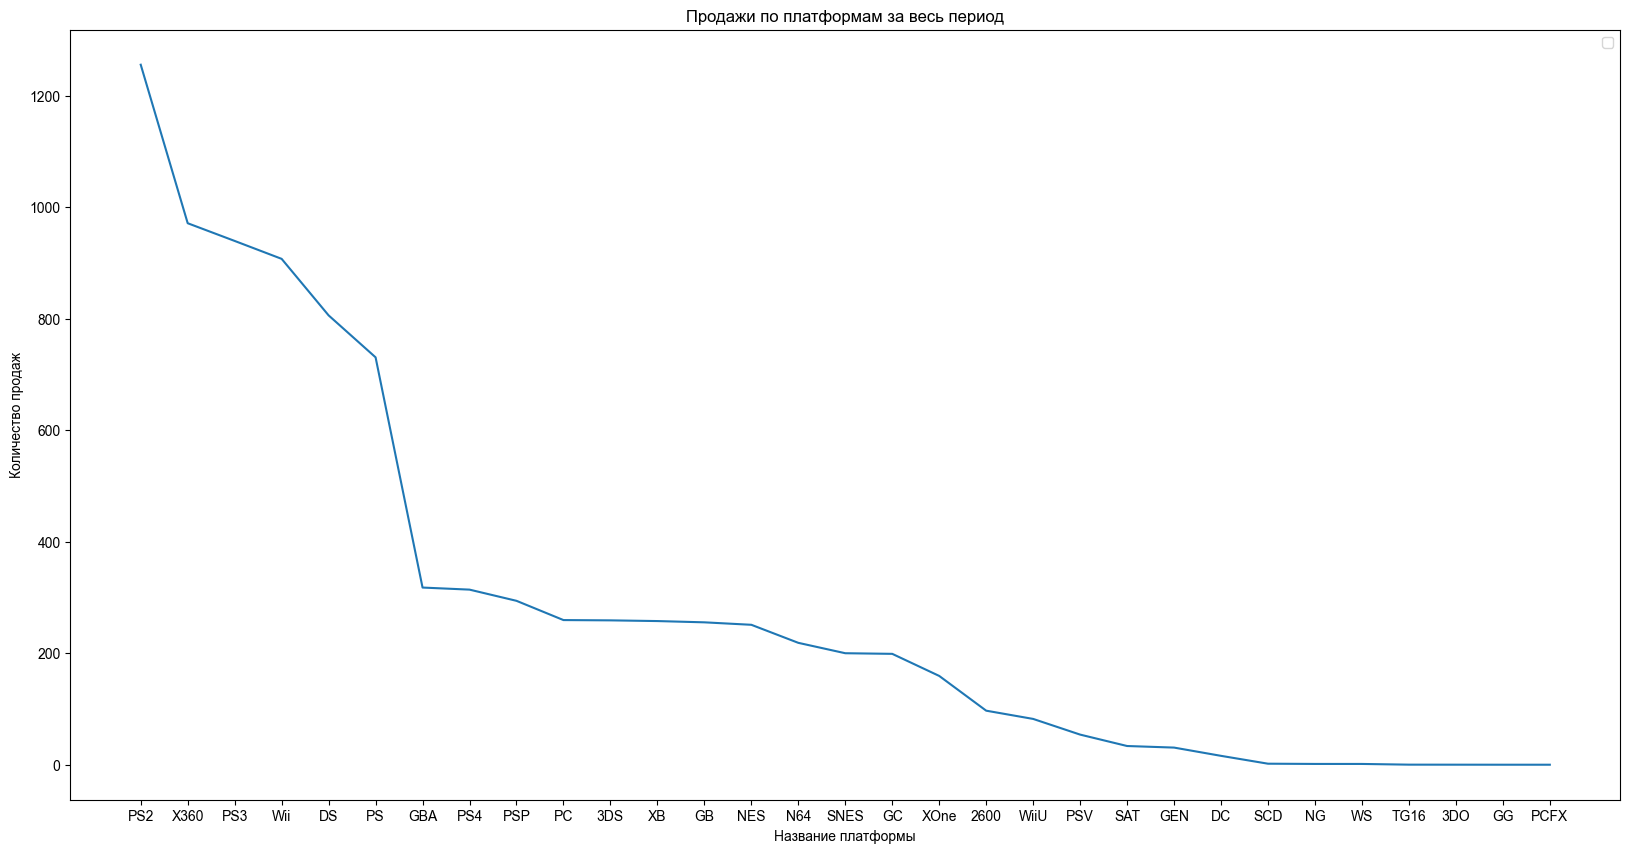

In [21]:
# Строим график продаж по платформам за весь период
platform_on_sales = data.pivot_table(
    index='platform', values='total_sales', aggfunc='sum').sort_values(by='total_sales', ascending=False)
plt.figure(figsize=(20,10))
sns.lineplot(data=platform_on_sales)
sns.set_style('whitegrid')
plt.title("Продажи по платформам за весь период")
plt.xlabel("Название платформы")
plt.ylabel("Количество продаж")
plt.legend('')
plt.show()

Лидирует платформа PS2. Многие слышали о ней. Кто-то даже играл.
Далее идут Xbox360, PS3 и Wii.
Самые редкие платформы - японские.

In [26]:
PS2 = data.query('platform =="PS2"').pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')
X360 = data.query('platform =="X360"').pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')
PS3 = data.query('platform =="PS3"').pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')
Wii = data.query('platform =="Wii"').pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')
DS = data.query('platform =="DS"').pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')


In [27]:

# Создаю сводную таблицу, где для каждой платформы указан ежегодный объём продаж
top_5_platforms = (
    PS2.merge(X360, how='outer', on='year_of_release', suffixes=('_PS2', '_X360'))
    .merge(PS3, how='outer', on='year_of_release', suffixes=('_PS3', '_PS3'))
    .merge(Wii, how='outer', on='year_of_release', suffixes=('_Wii', '_Wii'))
    .merge(DS, how='outer', on='year_of_release', suffixes=('_DS', '_DS'))
)

In [33]:
# Переименовываю названия столбцов для удобства
top_5_platforms.set_axis(['PS2', 'X360', 'PS3', 'Wii', 'DS'], axis='columns')
# Пропуски заменяю на 0, фильтрую значения от 1995 года и выше
top_5_platforms = top_5_platforms.query('year_of_release >= 1995').fillna(0) 

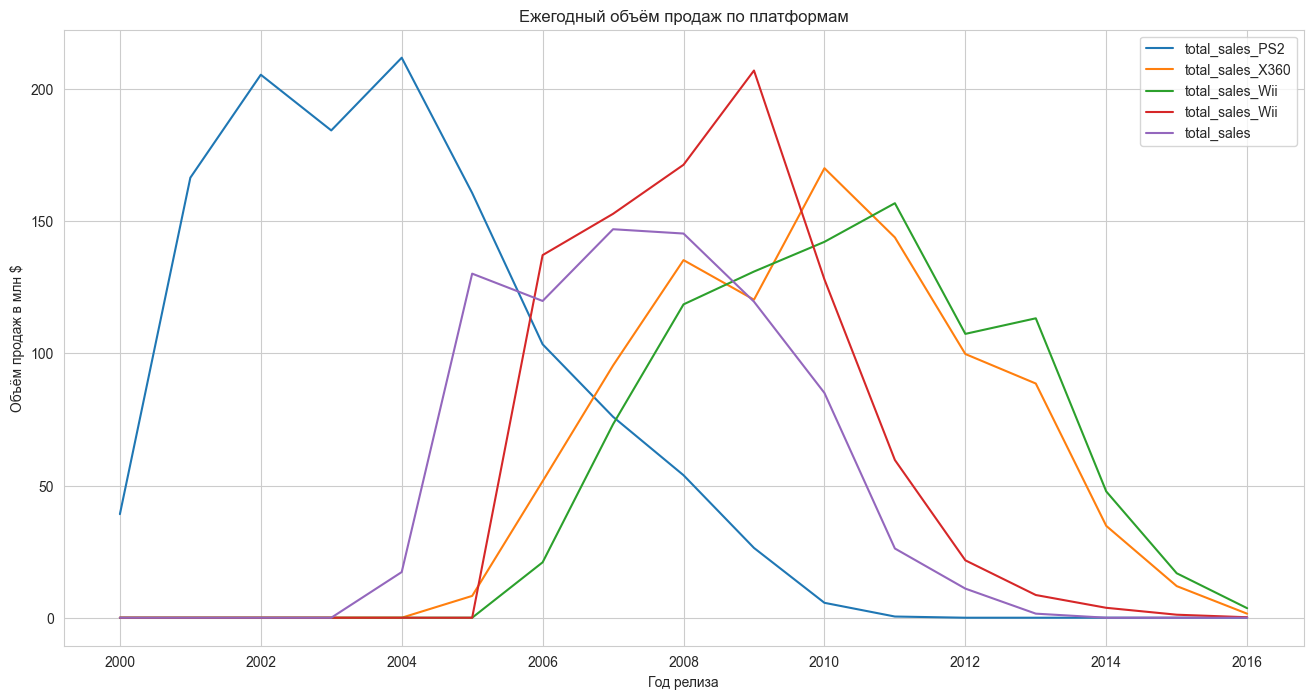

In [34]:
# Рисую график для визуального анализа полученных результатов
top_5_platforms.plot(figsize=(16, 8), title='Ежегодный объём продаж по платформам', grid=True).set(xlabel='Год релиза', ylabel='Объём продаж в млн $')
plt.show()

Мы можем увидеть, что в среднем цикл продаж составляет 10 лет для каждой платформы. За этот период игры под платформу продаются следующим образом: первые 5 лет высокие темпы продаж, последние 5 лет низкие темпы продаж (спад продаж). И жила бы консоль дольше, если б не выходили более новые консоли. Но это неизбежно, т.к. прогресс идет вперед и "железо" в старых консолях перестает отвечать техническим требованиям новых игр.
Железо не стоит на месте, оно эволюционирует вместе с людьми. Такой переход длится примерно 3-4 года, в так называемый "момент перехода" продажи игр под старое поколение платформ резко снижается, а под новое поколение резко растёт. Данная тенденция хорошо прослеживается на примере платформ PS2 и PS3. Стоит заметить, что такая тенденция характерна для всех поколений платформ, так как развитие игровой индустрии имеет циклы.
Вывод:
Актуальным периодом для дальнейшего анализа можно считать период: с 2012 по 2016 года.

____________________
Возьмем данные за соответствующий актуальный период. Отфильтруем таблицу и оставим только строки где дата релиза с 2013 по 2016 включительно, полученную таблицу запишем в новый датафрейм.

In [35]:
# Отфильтруем таблицу и запишем её в новый датафрейм
actual_data_games_sales = data.query('year_of_release >= 2014')
actual_data_games_sales.head(5)



,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,-1.0,-1.0,RP,14.63
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
47,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,-1.0,-1.0,RP,11.68
77,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58
87,Star Wars Battlefront (2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,-1.0,-1.0,RP,7.98


Посмотрим, какие платформы лидируют по продажам. Выберем несколько потенциально прибыльных платформ.

In [36]:
# Создадим таблицу методом pivot_table
best_sales_platform = pd.pivot_table(actual_data_games_sales, index='platform', 
                                     values='total_sales', aggfunc = 'sum')
best_sales_platform.sort_values('total_sales', ascending=False)



,total_sales
platform,
PS4,288.15
XOne,140.36
3DS,86.68
PS3,68.18
X360,48.22
WiiU,42.98
PC,27.05
PSV,22.40
Wii,5.07


Топ 5 платформ по миру: PS4, XOne, 3DS, PS3, X360. Их суммарный доход за 3 года около 1 миллиарда долларов.

Высокие показатели у PS4, XOne, 3DS, PS3 и X360, так как они заменяют предыдущее поколение игровых приставок. На убыль идут приставки предыдущего поколения WiiU, PC, PSV, Wii, PS соотвественно.

____________
Строим график «ящик с усами» по глобальным продажам игр в разбивке по платформам. 


count    1689.000000
mean        0.431883
std         1.056109
min         0.010000
25%         0.030000
50%         0.100000
75%         0.350000
max        14.630000
Name: total_sales, dtype: float64

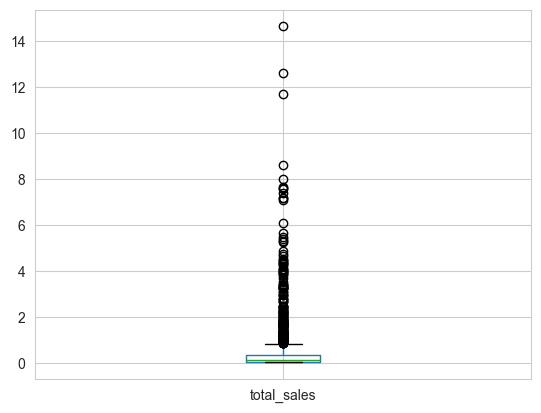

In [37]:
actual_data_games_sales.boxplot(column = 'total_sales')
actual_data_games_sales['total_sales'].describe()



count    376.000000
mean       0.766356
std        1.614969
min        0.010000
25%        0.057500
50%        0.185000
75%        0.690000
max       14.630000
Name: total_sales, dtype: float64

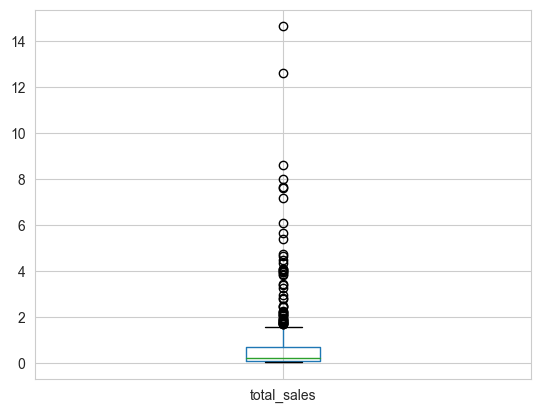

In [38]:
PS4_actual_data_games_sales = actual_data_games_sales.query('platform =="PS4"')
PS4_actual_data_games_sales.boxplot(column = 'total_sales')
PS4_actual_data_games_sales['total_sales'].describe()



count    219.000000
mean       0.311324
std        0.633059
min        0.010000
25%        0.040000
50%        0.110000
75%        0.325000
max        5.270000
Name: total_sales, dtype: float64

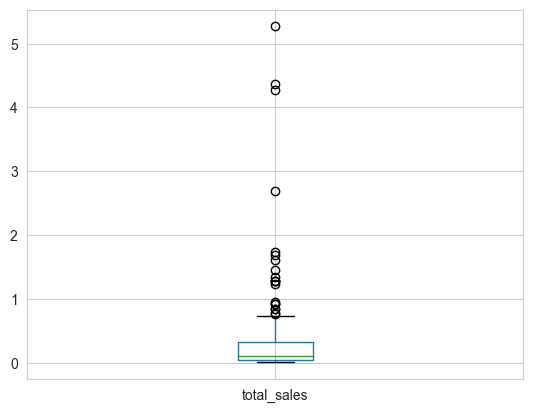

In [39]:
PS3_actual_data_games_sales = actual_data_games_sales.query('platform =="PS3"')
PS3_actual_data_games_sales.boxplot(column = 'total_sales')
PS3_actual_data_games_sales['total_sales'].describe()


count    228.000000
mean       0.615614
std        1.046513
min        0.010000
25%        0.050000
50%        0.205000
75%        0.632500
max        7.390000
Name: total_sales, dtype: float64

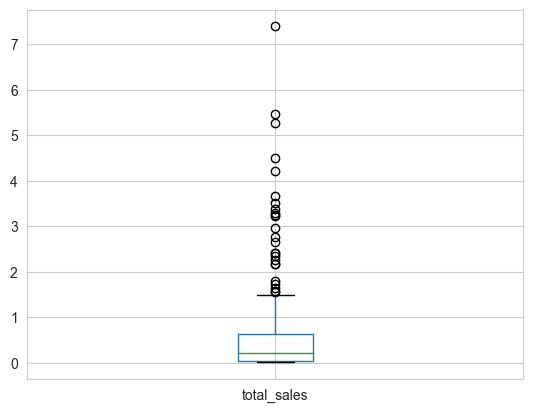

In [40]:
XOne_actual_data_games_sales = actual_data_games_sales.query('platform =="XOne"')
XOne_actual_data_games_sales.boxplot(column = 'total_sales')
XOne_actual_data_games_sales['total_sales'].describe()


count    111.000000
mean       0.434414
std        0.628967
min        0.010000
25%        0.070000
50%        0.180000
75%        0.505000
max        4.280000
Name: total_sales, dtype: float64

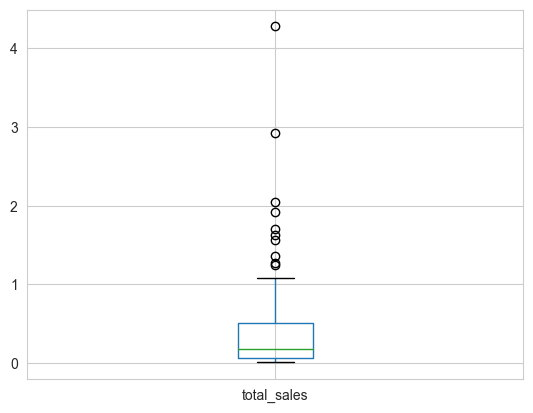

In [41]:
X360_actual_data_games_sales = actual_data_games_sales.query('platform =="X360"')
X360_actual_data_games_sales.boxplot(column = 'total_sales')
X360_actual_data_games_sales['total_sales'].describe()

count    212.000000
mean       0.408868
std        1.188368
min        0.010000
25%        0.030000
50%        0.090000
75%        0.250000
max       11.680000
Name: total_sales, dtype: float64

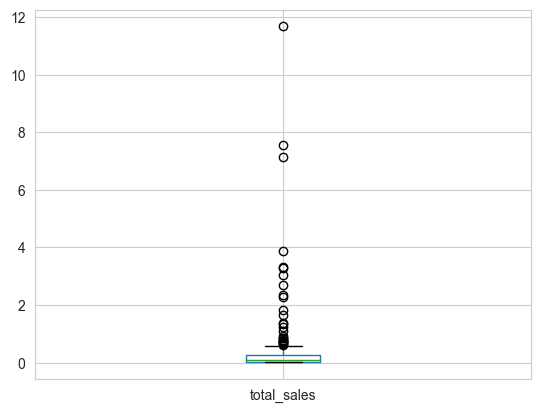

In [42]:
_3DS_actual_data_games_sales = actual_data_games_sales.query('platform =="3DS"')
_3DS_actual_data_games_sales.boxplot(column = 'total_sales')
_3DS_actual_data_games_sales['total_sales'].describe()

Рисуем диаграмму размаха, по актуальной выборке с полным перечнем платформ

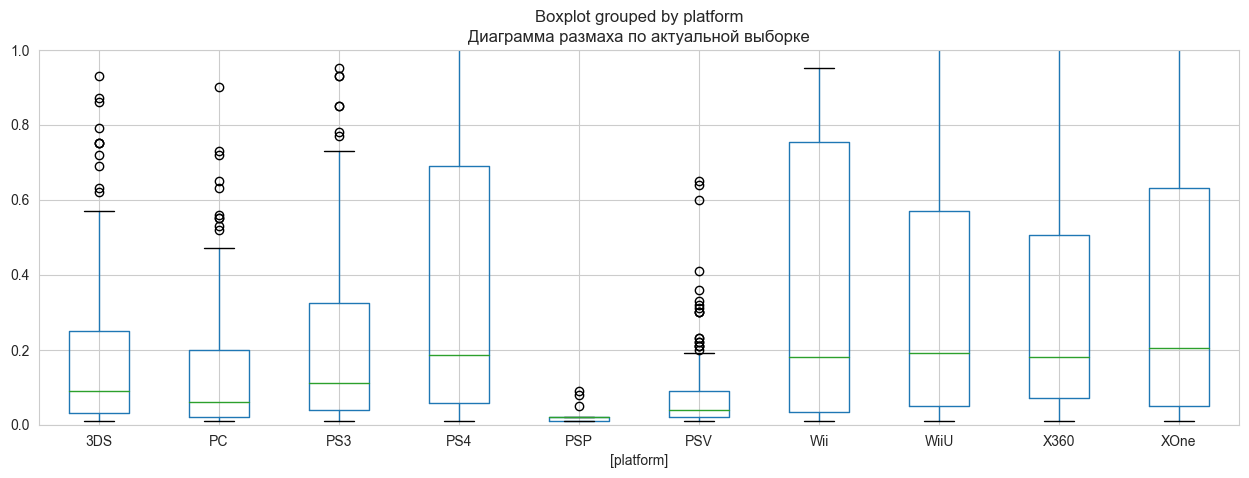

In [43]:
# рисуем диаграмму размаха 
boxplot = actual_data_games_sales.boxplot(column=['total_sales'], by = ['platform'], figsize = (15, 5))
#plt.ylim(0, 3)
plt.ylim(0, 1)
plt.title('Диаграмма размаха по актуальной выборке')
plt.grid(True)
plt.show() 

Проведем анализ по графику «ящик с усами». Показатели разнятся. Видим очень популярные игры, которые долго продаются и дают много прибыли, их мало. И много игр, которые смогли преодолеть порог в 400 тыс. долларов за выбранный период.  

Период 2014-2016 год  

Средняя выручка на игру по миру: 408 тыс. дол. 75% игр заработали до 350 тыс. Рекорд 11,680 млн.  
Средняя выручка на игру по платформе PS4: 408 тыс. 75% игр заработали до 690 тыс. Рекорд 11,680 млн.   
Средняя выручка на игру по платформе PS3: 434 тыс. 75% игр заработали до 325 тыс. Рекорд 4,280 млн.  
Средняя выручка на игру по платформе XOne: 615 тыс. 75% игр заработали до 632 тыс. Рекорд 7,390 млн.  
Средняя выручка на игру по платформе X360: 311 тыс. 75% игр заработали до 505 тыс. Рекорд 5,270 млн.  
Средняя выручка на игру по платформе 3DS: 408 тыс. 75% игр заработали до 250 тыс. Рекорд 14,6 млн. 

Для PS4 и 3DS видна положительная тенденция к росту продаж. Средняя больше 3го квантиля(75%), это значит на эти платформы делаются более популярные и продаваемые игры, чем на XOne, PS3 и X360.  

___________
Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами. 

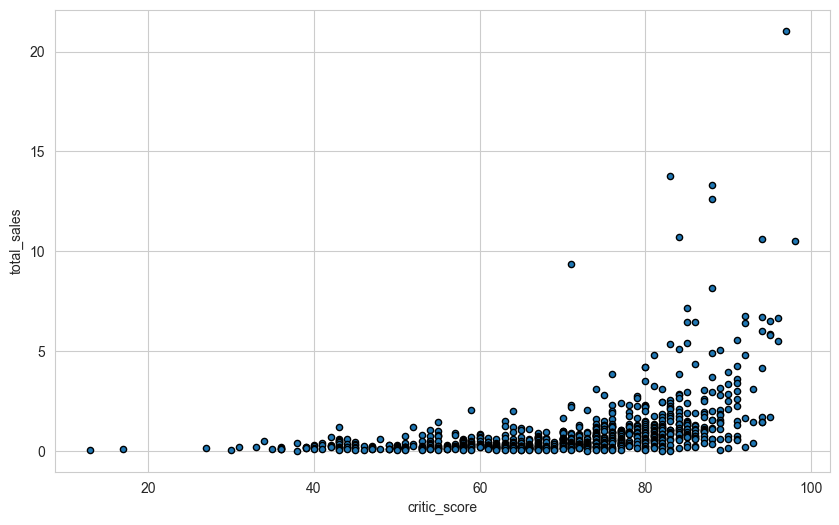

In [46]:
# Диаграмма рассеяния зависимости общей суммы продаж игры от отзывов критиков:
games_ps3 = data[(data['platform'] == 'PS3') & (data['critic_score'] > 0)].copy()
games_ps3.plot(kind='scatter', x='critic_score', y='total_sales', ec='black', figsize=(10,6))
plt.show() 

Чем выше средний рейтинг критиков, тем выше и средний уровень выручки с продажи игр. Это более чем логично, поскольку чем качественнее игра, тем больше прибыли она принесет разработчику и издателю.



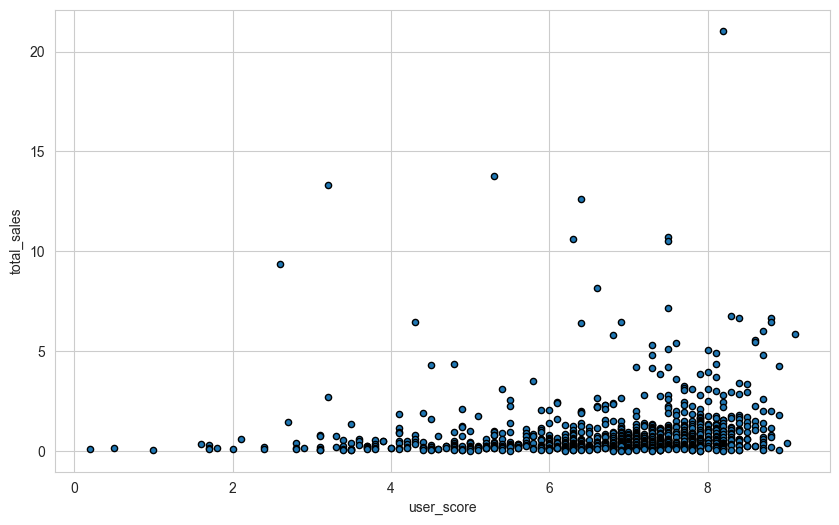

In [47]:
# Диаграмма рассеяния зависимости от отзывов пользователей
games_ps3 = data[(data['platform'] == 'PS3') & (data['user_score'] > 0)].copy()
games_ps3.plot(kind='scatter', x='user_score', y='total_sales', ec='black', figsize=(10,6))
plt.show() 

Точно такая же картина, правда так называемых выбросов больше - когда рейтинг пользователей не велик, но тем не менее игра собирает прибыль. 
К примеру Cyberpunk 2077, Batman Arkham Knight, The Last of Us 2, Mass effect 3, Mass effect Andromeda, Star Wars Battlefront II, Warcraft 3 Reforged. Это как раз та ситуация, когда все покупают игру, принося разработчикам прибыль, а потом горит релиз.  

Если взять платформу PS4, то там важными критерием будет качество игры. Поэтому присутствует прямая корреляция между прибылью и рейтингом критиков. Обратная корреляция по игрокам не несет сильного смысла.

Важно заметить, что на мнение игроков влияет рейтинг. То есть, чем выше ценит игру критик, тем выше оценит её игрок.

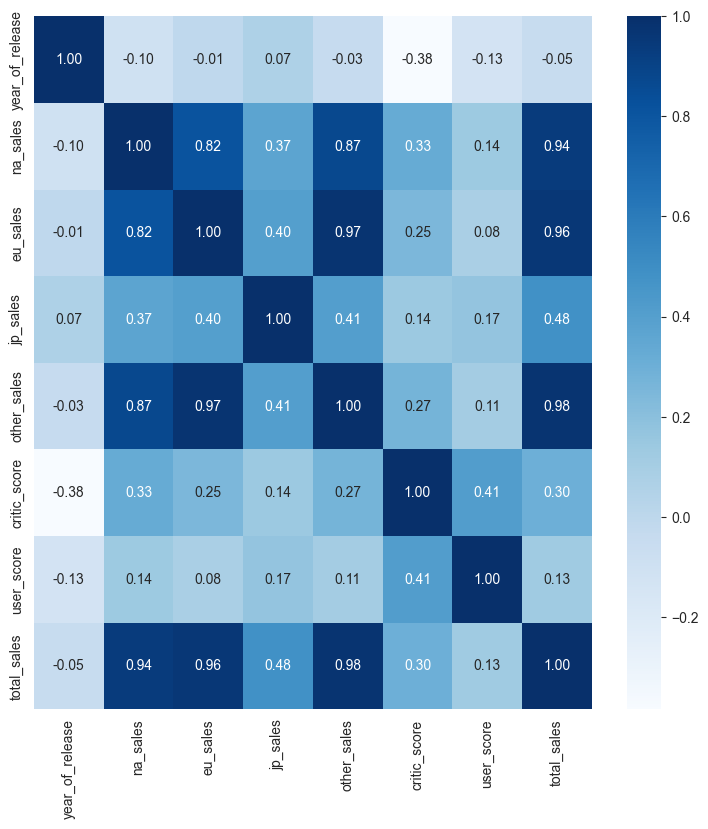

In [50]:
# Выберем только числовые столбцы для расчета корреляции
numerical_columns = games_ps3.select_dtypes(include=[np.number])

# Создадим матрицу корреляции для числовых столбцов
correlation_matrix = numerical_columns.corr()

# Создадим тепловую карту
plt.figure(figsize=(9, 9))
sns.heatmap(correlation_matrix, annot=True, cmap="Blues", fmt='.2f', annot_kws={'size': 10})
plt.show()


Вытащим оценки и стоимость, посмотрим кореляцию

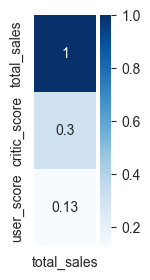

In [51]:
#games_ps3 = data[(data['platform'] == 'PS3') & (data['user_score'] > 0)].copy()
games_ps3_filtered = data[(data['platform'] == 'PS3') & (data['user_score'] > 0)].copy()
games_ps3_filtered = games_ps3[['total_sales' ,'critic_score', 'user_score']]
plt.figure(figsize=(1,3))
sns.heatmap(games_ps3_filtered.corr()[['total_sales']].sort_values(by='total_sales', ascending=False), cmap="Blues", 
            annot=True, annot_kws={'size':10})
plt.show() 

Сильнее всего на конечную стоимость влияет оценка критиков. Гораздо меньше, практически не влияет - оценка пользователей.

Произведем оценку корреляции по топовым платформам

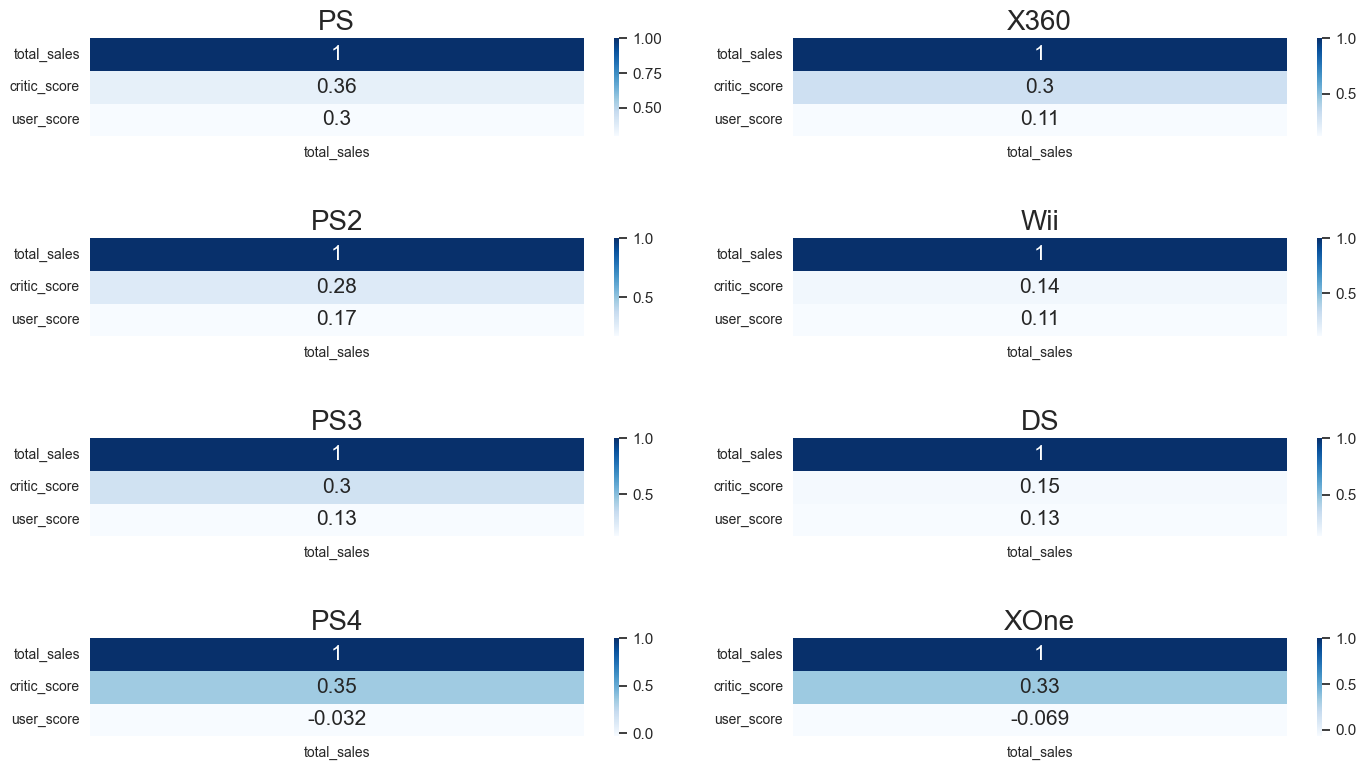

In [53]:
# Составим карту корреляции по платформам
#top_platforms = ['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS', 'PS4', 'XOne']
top_platforms = ['PS', 'X360', 'PS2', 'Wii', 'PS3', 'DS', 'PS4', 'XOne']
rows = len(top_platforms) // 2
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(15,8.5))
count = 0
for r in range(rows):
    for c in range(cols):
        curr_platform = top_platforms[count]
        df_prep = data[(data['platform'] == curr_platform) & (data['user_score'] > 0)].copy()
        
        df_filtered = df_prep[['total_sales' ,'critic_score', 'user_score']]
        sns.set(font_scale=1.0)
        ax = sns.heatmap(df_filtered.corr()[['total_sales']].sort_values(by='total_sales', ascending=False), 
                         cmap="Blues", annot=True, annot_kws={'size':15}, ax=axes[r,c])
        ax.set_title(curr_platform, fontsize=20)
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
        plt.tight_layout(pad=3)
        count += 1

Данные по корреляции между выручкой и оценкой по платформам PS2, X360, PS3, PS и XOne так или иначе совпадают с общими данными по датафрейму.  
Можно выделить Wii и DS, как платформы с наименьшей зависимостью.
Имеются платформы, где оценка критиков, сильнее "определяет" конечную выручку продукта, чем оценка пользователей. Это платформы DS, PS4 и Xone. В случае с DS скорее всего причина в том, что приставка родом из азии, соответственно, далеко вся часть игроков принимает участие в оценке игр на эту платформу. Про PS4 и Xone на тот момент не успели озавестись большим колличеством отзывов.

_________

А теперь посмотрим на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?


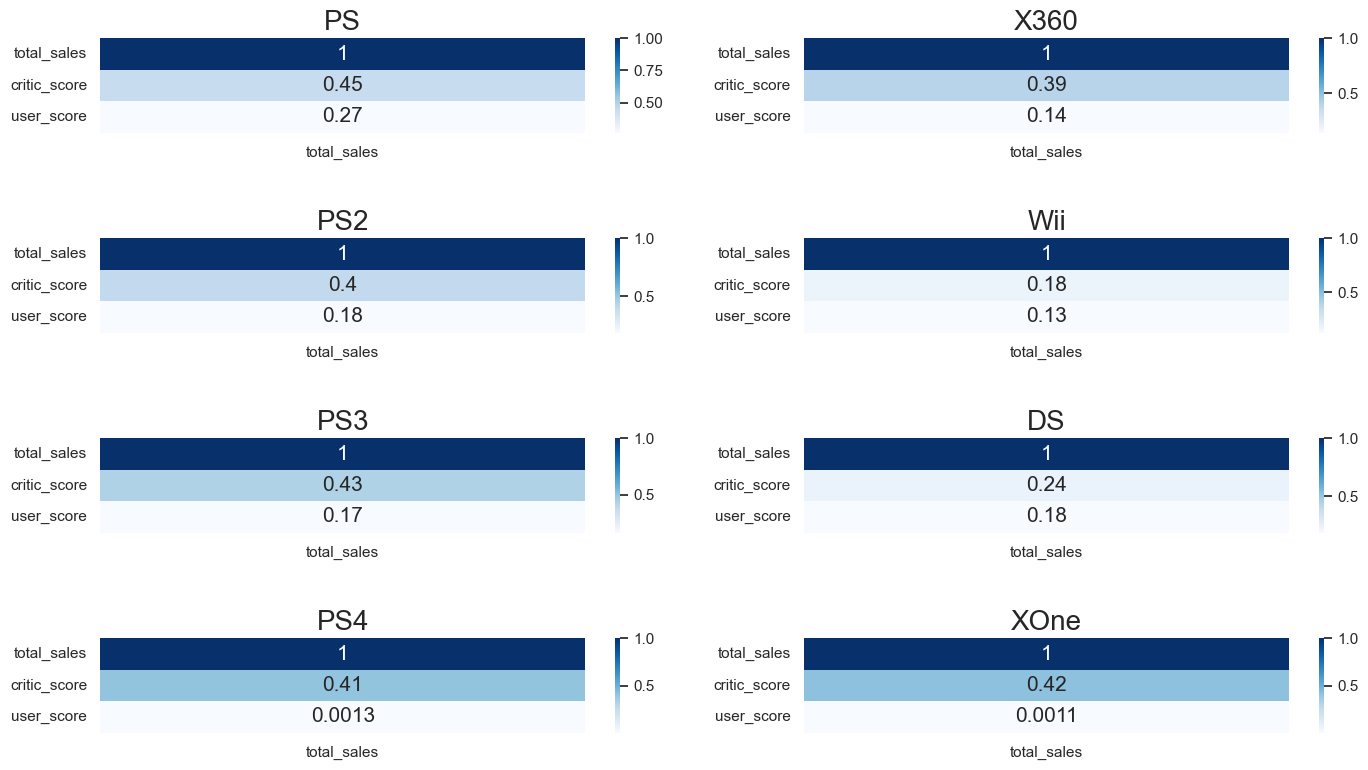

In [54]:
# Составим карту корреляции по платформам
#top_platforms = ['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS', 'PS4', 'XOne']
top_platforms = ['PS', 'X360', 'PS2', 'Wii', 'PS3', 'DS', 'PS4', 'XOne']
rows = len(top_platforms) // 2
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(15,8.5))
count = 0
for r in range(rows):
    for c in range(cols):
        curr_platform = top_platforms[count]
        df_prep = data[(data['platform'] == curr_platform) & (data['critic_score'] > 0)].copy()
        
        df_filtered = df_prep[['total_sales' ,'critic_score', 'user_score']]
        sns.set(font_scale=1.0)
        ax = sns.heatmap(df_filtered.corr()[['total_sales']].sort_values(by='total_sales', ascending=False), 
                         cmap="Blues", annot=True, annot_kws={'size':15}, ax=axes[r,c])
        ax.set_title(curr_platform, fontsize=20)
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
        plt.tight_layout(pad=3)
        count += 1

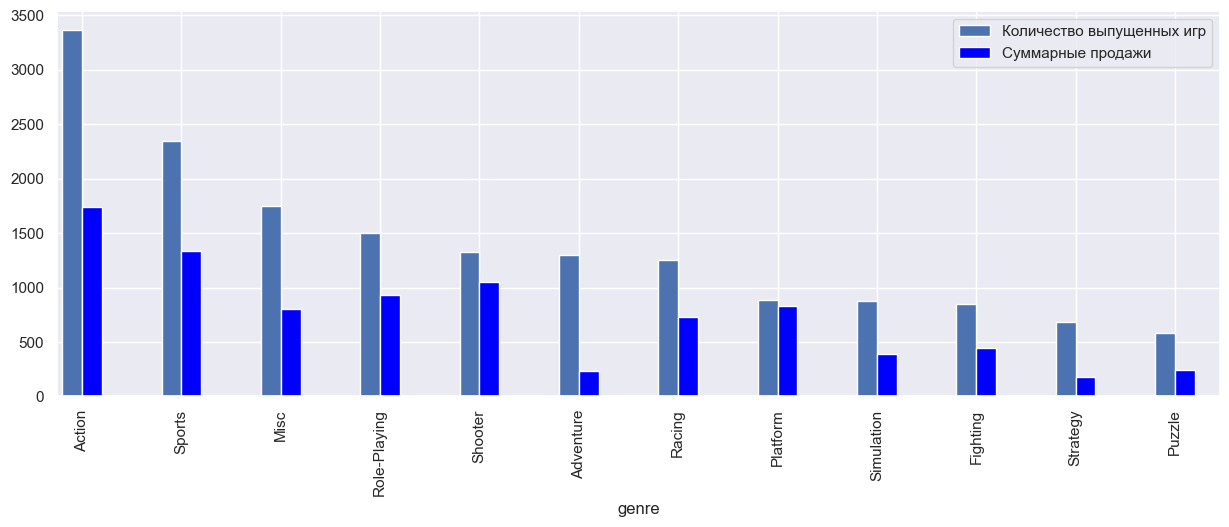

In [55]:
# общий период
ax = plt.gca()

pivot = data.groupby('genre').agg({'name': 'count', \
    'total_sales': 'sum'}).sort_values(by='name', ascending=False)

plot1 = pivot['name']
plot1.plot(kind='bar', figsize=(15,5), ax=ax, width=0.2, position=1)

plot2 = pivot['total_sales']
plot2.plot(kind='bar', figsize=(15,5), ax=ax, width=0.2, color='#0000FF', position=0)

ax.legend(['Количество выпущенных игр', 'Суммарные продажи'])
plt.show() 

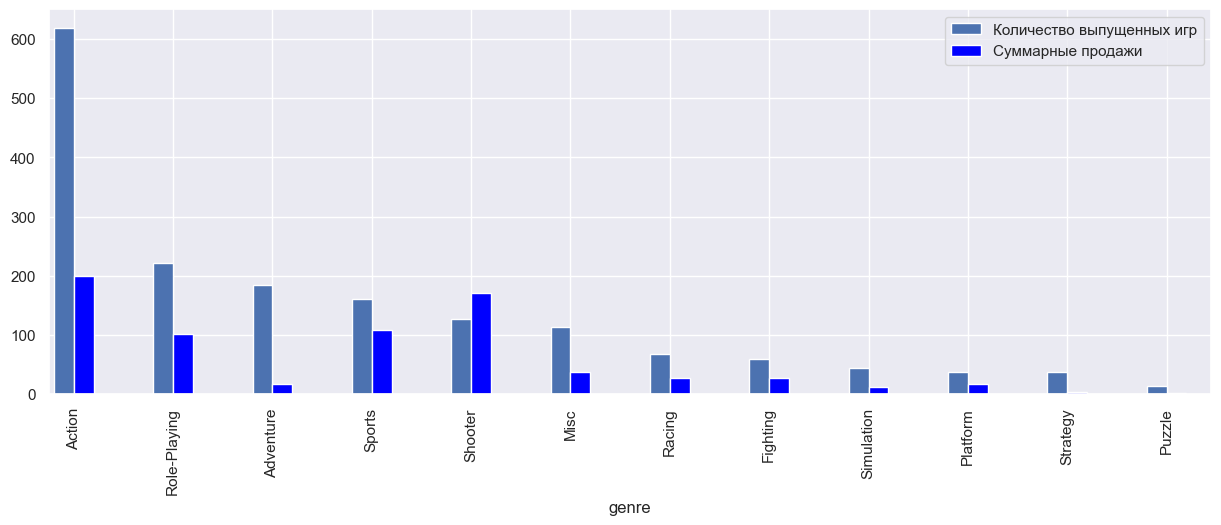

In [56]:
# актуальный период
ax = plt.gca()

pivot = actual_data_games_sales.groupby('genre').agg({'name': 'count', \
    'total_sales': 'sum'}).sort_values(by='name', ascending=False)

plot1 = pivot['name']
plot1.plot(kind='bar', figsize=(15,5), ax=ax, width=0.2, position=1)

plot2 = pivot['total_sales']
plot2.plot(kind='bar', figsize=(15,5), ax=ax, width=0.2, color='#0000FF', position=0)

ax.legend(['Количество выпущенных игр', 'Суммарные продажи'])
plt.show() 

Мы можем смотреть и анализировать как общий период, так и актуальный период. Это дает нам возможность более детального анализа. Так же можем оценить среднее колличество проданных копий в актуальном периоде.

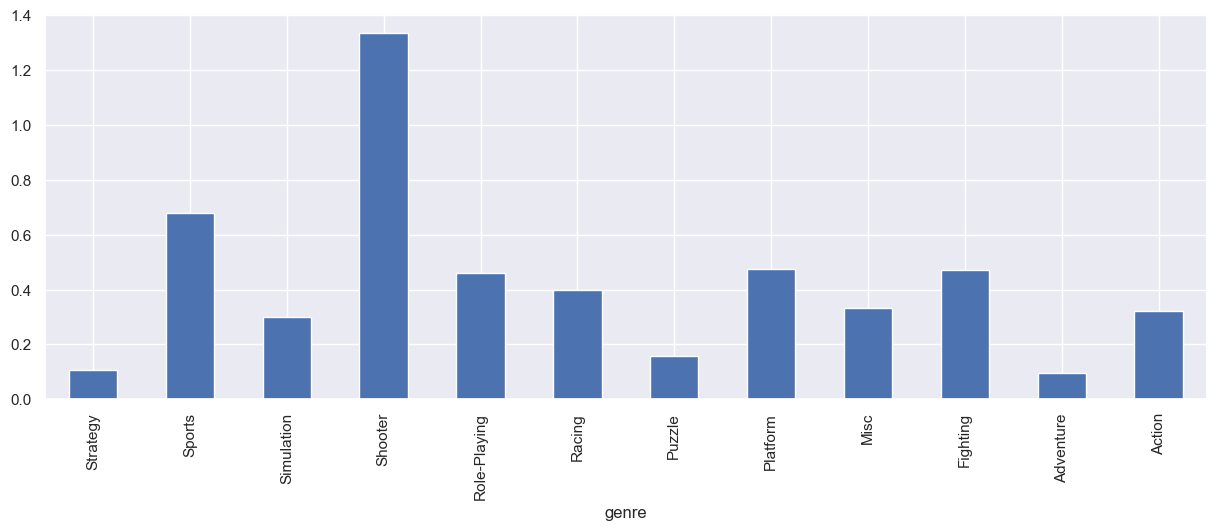

In [57]:
# возьмем средние колличество проданных копий - для поиска прибыльного жанра
genre_sales_category = (actual_data_games_sales.groupby('genre')['total_sales'].agg(['count', 'mean']).nlargest(columns='count', n=12)).sort_values(by='genre', ascending=False)
genre_sales_category['mean'].plot.bar(figsize=(15, 5))
plt.show() 


Если брать общий период, то больше всего игр жанра Action. За ними идут игры спортивного жанра. Причем даже учитывая то, что игр жанра "Спорт" заметно меньше на рынке (на треть от Action), выручка от продаж у них практически одинаковая. Это значит, что спортивные игры, в среднем, стоят дороже, чем шутеры. Ну и это ожидаемо, шутеры выходят преимущественно на ПК, тогда как спортивные игры - на консолях. А там явно и дела с пиратством лучше обстоят, да и сами лицензионные копии дороже.
Если рассматривать актуальный период, то ситуация меняется. На первом месте все тот же жанр Action, что не скажешь о втором месте. В актуальном периоде Шутеры показали лучший результат в плане суммарных продаж. Видимо на актуальный период приходится активный спрос, в Шутеры играли все. Что касается среднего колличества проданных копий, то Шутеры выбились вперед.

______
Для нас так же важно увидеть средние и суммароеные цифры по продажам, для этого создаем таблицу.

In [58]:
# создаем таблицу методом pivot_table()
genre_pivot_table = pd.pivot_table(actual_data_games_sales, index='genre', \
    values='total_sales', aggfunc='mean')
genre_pivot_table.sort_values('total_sales', ascending=False)

,total_sales
genre,
Shooter,1.335469
Sports,0.680000
Platform,0.476053
Fighting,0.470333
Role-Playing,0.459005
Racing,0.398841
Misc,0.332301
Action,0.322068
Simulation,0.298409


In [59]:
# создаем таблицу методом pivot_table()
genre_pivot_table = pd.pivot_table(actual_data_games_sales, index='genre', values='total_sales', aggfunc='sum')
genre_pivot_table.sort_values('total_sales', ascending=False)

,total_sales
genre,
Action,199.36
Shooter,170.94
Sports,109.48
Role-Playing,101.44
Misc,37.55
Fighting,28.22
Racing,27.52
Platform,18.09
Adventure,17.55



Поскольку разработчики продолжают экспериментировать с игровыми жанрами и создавать новые, сейчас нам известны сотни жанров компьютерных игр.

Самыми прибыльными жанрами можно считать экшен(Action), шутеры(Shooter), спортивные игры (Sports) и ролевые игры (Role-Playing).

Популярность экшена обусловлена историей создания игр и желания людей проверить свои физические возможности, в том числе координацию глаз и рук и скорость реакции. Схожий с ним тип жанра Misc.

Популярность шутеров, спортивых игр и ролевых игр обусловлена тем, что в большинстве из них играют несколько игроков одновременно. Так получаются соревнования формата 1х1, 2х2, 3х3, 5х5 и т.д. (В России и некоторых других странах постсоветского пространства жанр изначально был назван как «стрелялка»).

Ролевые игры затягивают игроков своей сложностью к прохождению игры и соответсвенно в нее играют часто и даже перепроходят много раз, что увеличивает интерес к обновлениям или повышают вероятность рассказа об этой игре близким.

В период 2013-2016 год не пользуются популярностью приключения (Adventure), симуляторы(Simulation) стратегии реального времени или пошаговые (Strategy) и головоломки (Puzzle).

Головоломки были популярны с 80х годов, но сейчас становится все меньше ценителей этого жанра. Текущее поколение хочет захватывающих действий. Приключение, хоть и появилось позже, оно имеет похожую тенденцию.

Симуляторы - это повторение реальной жизни или аспектов реальной жизни сейчас, в прошлом или в будущем. Этот жанр на любителя делать так, как ему хочется.

Стратегии редко когда поднимаются в рейтингах по продажам в ввиду еще большей трудности и иногда неторопливости процесса. Простыми словами этот жанр на любителя.

count    38.000000
mean      0.476053
std       0.722561
min       0.010000
25%       0.062500
50%       0.140000
75%       0.467500
max       3.210000
Name: total_sales, dtype: float64

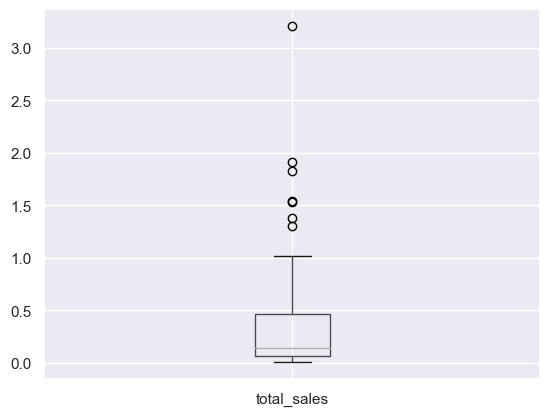

In [60]:
platform_actual_data_games_sales = actual_data_games_sales.query('genre =="Platform"')
platform_actual_data_games_sales.boxplot(column = 'total_sales')
platform_actual_data_games_sales['total_sales'].describe()


count    128.000000
mean       1.335469
std        2.050567
min        0.010000
25%        0.172500
50%        0.515000
75%        1.617500
max       14.630000
Name: total_sales, dtype: float64

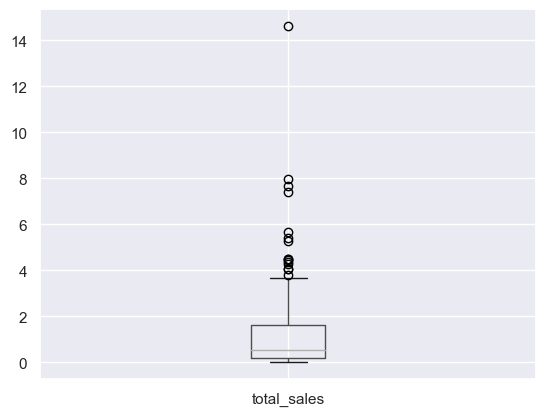

In [61]:
shooter_actual_data_games_sales = actual_data_games_sales.query('genre =="Shooter"')
shooter_actual_data_games_sales.boxplot(column = 'total_sales')
shooter_actual_data_games_sales['total_sales'].describe()

count    161.000000
mean       0.680000
std        1.239736
min        0.010000
25%        0.060000
50%        0.180000
75%        0.640000
max        8.580000
Name: total_sales, dtype: float64

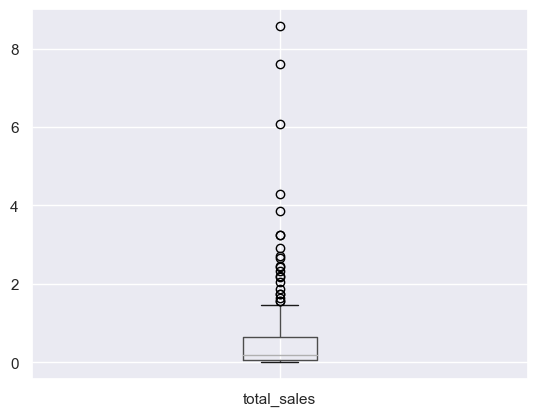

In [62]:
sports_actual_data_games_sales = actual_data_games_sales.query('genre =="Sports"')
sports_actual_data_games_sales.boxplot(column = 'total_sales')
sports_actual_data_games_sales['total_sales'].describe()

count    60.000000
mean      0.470333
std       1.188053
min       0.010000
25%       0.060000
50%       0.125000
75%       0.320000
max       7.550000
Name: total_sales, dtype: float64

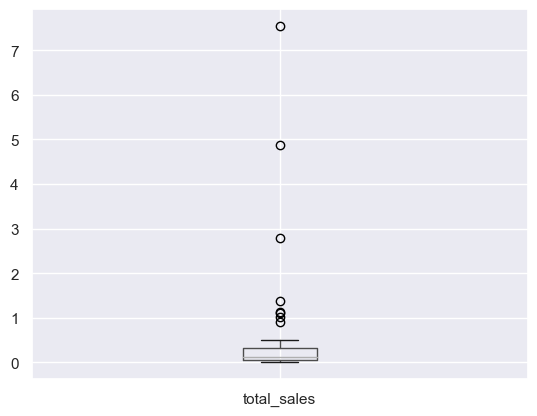

In [63]:
fighting_actual_data_games_sales = actual_data_games_sales.query('genre =="Fighting"')
fighting_actual_data_games_sales.boxplot(column = 'total_sales')
fighting_actual_data_games_sales['total_sales'].describe()

count    619.000000
mean       0.322068
std        0.798181
min        0.010000
25%        0.030000
50%        0.090000
75%        0.280000
max       12.620000
Name: total_sales, dtype: float64

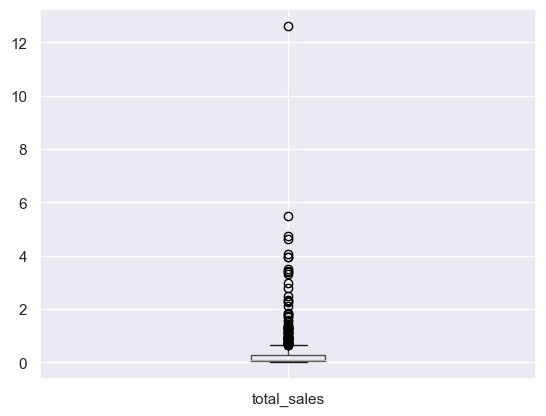

In [64]:

action_actual_data_games_sales = actual_data_games_sales.query('genre =="Action"')
action_actual_data_games_sales.boxplot(column = 'total_sales')
action_actual_data_games_sales['total_sales'].describe()

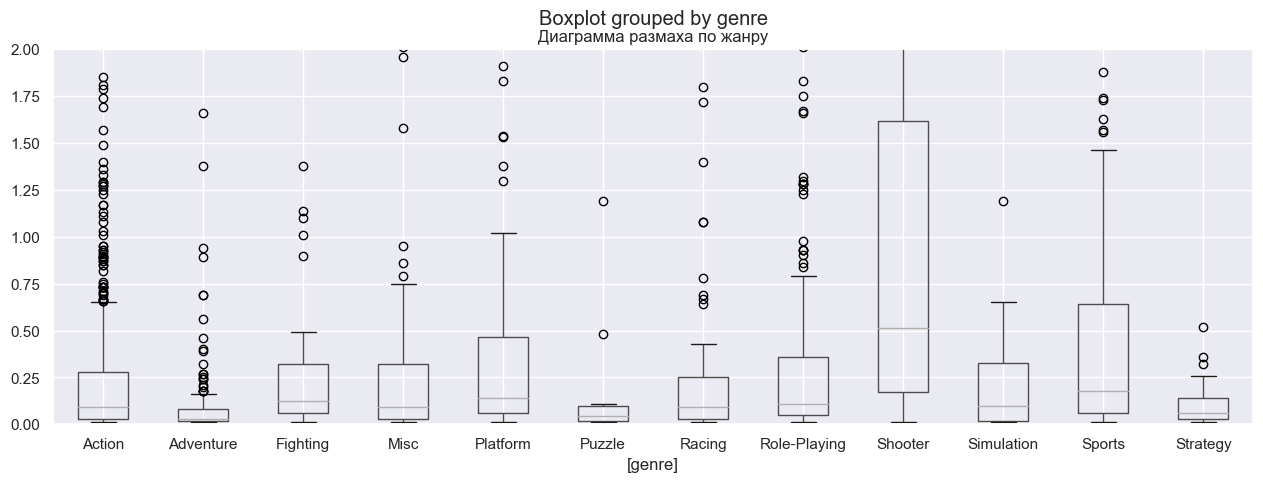

In [65]:
# рисуем диаграмму размаха 
boxplot = actual_data_games_sales.boxplot(column=['total_sales'], by = ['genre'], figsize = (15, 5))
plt.ylim(0, 2)
plt.title('Диаграмма размаха по жанру')
plt.grid(True)
plt.show() 

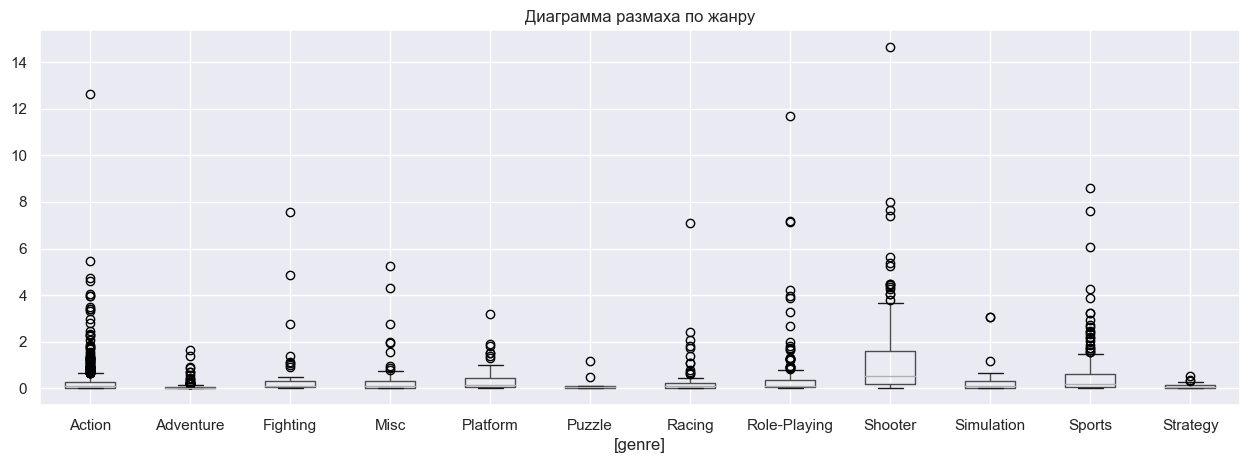

In [66]:
# check
boxplot = actual_data_games_sales.boxplot(column=['total_sales'], by = ['genre'], figsize = (15, 5))
# plt.ylim(0, 2)
plt.title('Диаграмма размаха по жанру')

plt.suptitle('') # уберем служебную информацию

plt.grid(True)
plt.show() 

Проведем анализ по графику «ящик с усами». Показатели разнятся. Видим очень популярные жанры, которые долго продаются и дают много прибыли, их мало. 

Период 2014-2016 год  

**Platform**  
Средняя - 476. Медиана по выручке на игру по жанру Platform: 467 тыс.  Рекорд 3,21 млн.  
**Shooter**  
Средняя - 1,335. Медиана по выручке на игру по жанру Shooter: 1,617 тыс.  Рекорд 14.63 млн.  
**Sports**  
Средняя - 680. Медиана по выручке на игру по жанру Sports: 640 тыс.  Рекорд 8,58 млн.   
**Fighting**    
Средняя - 470. Медиана по выручке на игру по жанру Fighting: 320 тыс.  Рекорд 7,5 млн.  
**Action**   
Средняя - 322. Медиана по выручке на игру по жанру Action: 280 тыс. Рекорд 12,6 млн. 

Для всех выбранных жанров видна положительная тенденция к росту продаж. Средняя больше 3го квантиля(75%), это значит на эти жанры делаются более популярные и продаваемые игры, чем на остальные. Не дотягивает до остальных лишь жанр Shooter.  
Что касается выбросов для игроманов, они есть у всего нашего топ-5. Это значит, что каждая из них способна выпустить наиболее привлекательные игры, за которые готовы платить ценители.

<a id='step4'></a> ***Шаг 4. Составим портрет пользователя каждого региона***

+ Определите для пользователя каждого региона (NA, EU, JP):  
+ Самые популярные платформы (топ-5). Опишите различия в долях продаж.  
+ Самые популярные жанры (топ-5). Поясните разницу.  
+ Влияет ли рейтинг ESRB на продажи в отдельном регионе?

Составим функцию для прорисовки графиков top_in_regions_plot:

In [67]:
def top_in_regions_plot(groupby, region_sales, ax):
    pivot = data.groupby(groupby).agg({region_sales: 'sum'}).sort_values(by=region_sales, ascending=False)[:5]
    title_dict = {'na_sales': 'North America Sales', 'eu_sales': 'Europe Sales', 'jp_sales': 'Japan Sales'}
    color_dict = {'na_sales': 'royalblue', 'eu_sales': 'gray', 'jp_sales': 'red'}
    plot = pivot.plot(kind='bar', ec='black', title=title_dict[region_sales], ax=axes[ax], 
                   fontsize=18, color=color_dict[region_sales], rot=20)
    plot.legend(prop={'size':17})
    plot.set_xlabel('')
    plot.title.set_size(20)


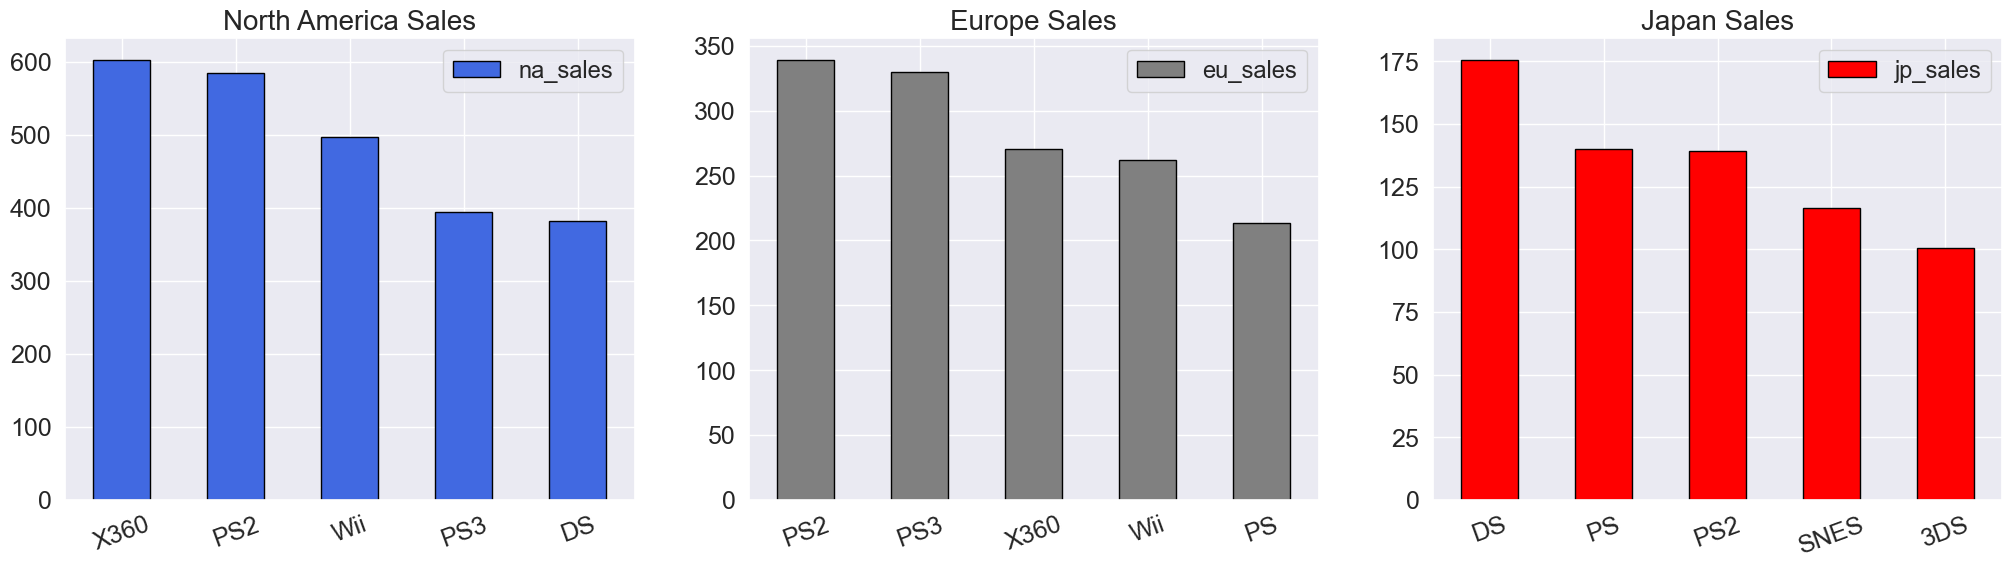

In [68]:
fig, axes = plt.subplots(1, 3, figsize=(25,6))

top_in_regions_plot('platform', 'na_sales', 0)
top_in_regions_plot('platform', 'eu_sales', 1)
top_in_regions_plot('platform', 'jp_sales', 2)

По графику можем увидеть, что в Северной Америке популярны приставки прошлого поколения X360 и PS2. Немного отстает Wii. Топ-4 и топ-5 - PS3 и DS соответственно.

В Европе плюс-минус одинаково популярны PS2 и PS3. За ними X360, Wii и PS.

В Японии лидер - DS. За ними американские PS и PS2. Далее чисто японские SNES и 3DS.

Естественно нужно понимать, что исследование мы проводим не по свежим данным. Сейчас всё может быть иначе.


Теперь оценим популярность по жанрам

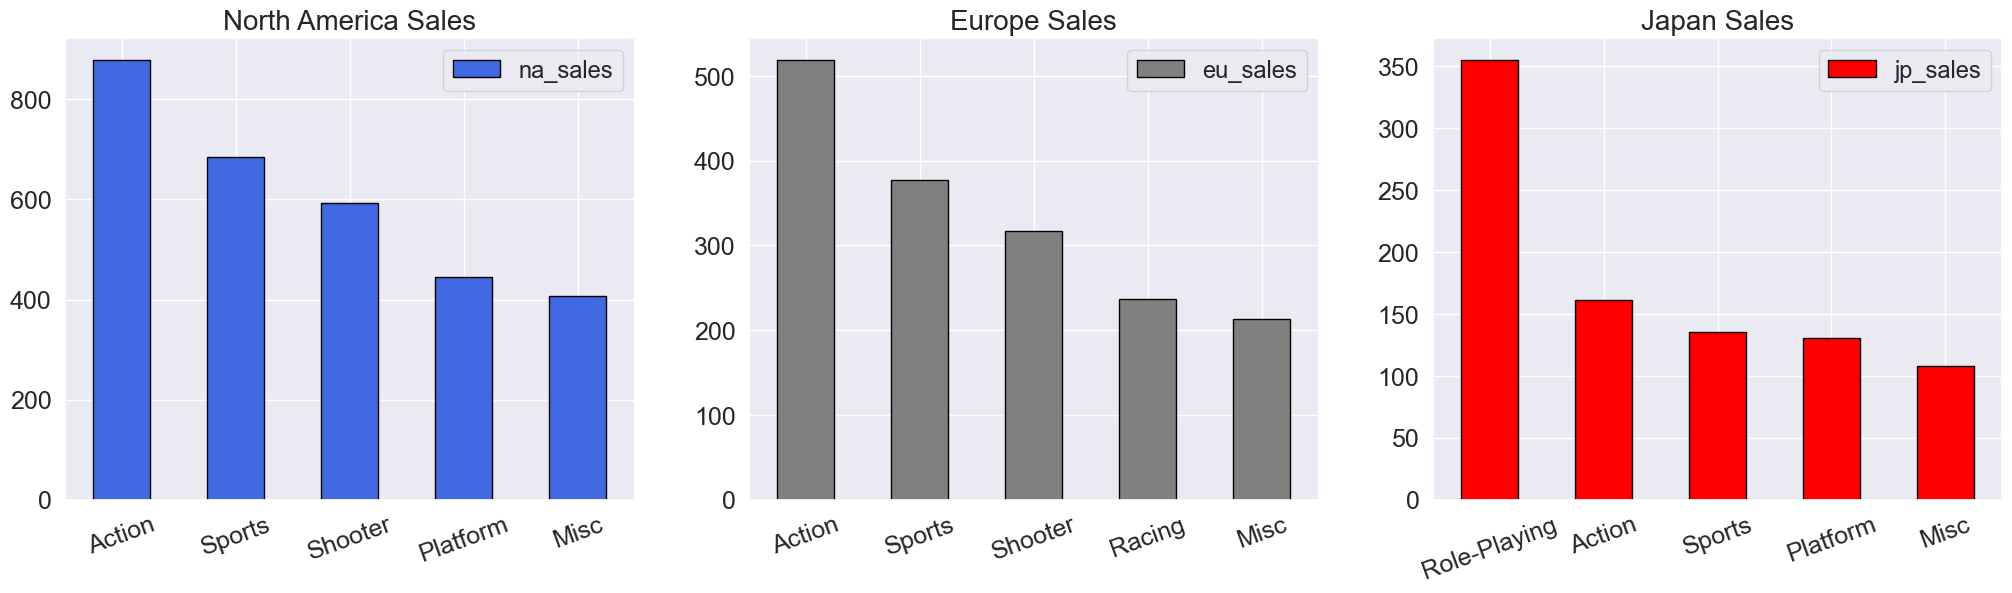

In [69]:
fig, axes = plt.subplots(1, 3, figsize=(25,6))

top_in_regions_plot('genre', 'na_sales', 0)
top_in_regions_plot('genre', 'eu_sales', 1)
top_in_regions_plot('genre', 'jp_sales', 2)


Популярные жанры Северной Америки и Европы похожи. И там, и там живут любители экшна, спортивных игр и шутеров. В Северной Америке больше играют в платформеры, в Европе же чаще выбирают гонки. Менее популярным жанром является Misc.

В Японии приоритеты в выборе жанров разительно отличаютя - на первом месте ролевые игры, причем с довольно большим отрывом от остальных жанров. Далее экшны и спортивные игры. Платформеры и Misc, как и в Северной Америке - менее популярны.

_________
Выясним, влияет ли рейтинг ESRB на продажи в отдельном регионе?

***Рейтинг Entertainment Software Rating Board (ESRB)***
  
«E» («Everyone») — «Для всех»: Содержание вполне подходит для всех возрастов. Такие игры могут понравиться и взрослым. Игры с этим рейтингом могут содержать минимальное насилие, в основном «мультяшного» характера. Первоначально "K-A" ("Kids to Adults"): 

«E10+» («Everyone 10 and older») — «Для всех от 10 лет и старше»: Проекты с данным рейтингом могут содержать больше мультипликационного или мягкого насилия, или несколько откровенные сцены, или минимальное количество крови. Рейтинг был принят ESRB 2 марта 2005 года.
 
«T» («Teen») — «Подросткам»: Игра подходит для лиц от 13 лет. Проекты из данной категории могут содержать насилие, непристойные сцены, грубый юмор, в меру откровенное сексуальное содержимое, кровь или нечастое использование ненормативной лексики.


«M» («Mature») — «Для взрослых»: Материалы игры не подходят для лиц младше 17 лет. Проекты с данным рейтингом могут содержать жестокое насилие, большое количество крови с расчленением, непристойные сексуальные сцены или грубую ненормативную лексику.

«RP» («Rating Pending») — «Рейтинг ожидается»: Продукт был отправлен в ESRB и ожидает присвоения рейтинга. Данный логотип используется только на рекламных презентациях и в демо-версиях игр до официальной даты выпуска в продажу:  

Мы значением «RP» заполнили пропуски, поэтому считаю уместным не включать значения в анализ.



In [70]:
ESRB_dict = {'E': 'Для всех', 'E10+': 'От 10 лет и старше', 'T': 'Подросткам', 'M': 'Для взрослых', 'RP': 'Рейтинг ожидается»'}

In [71]:
data['ESRB_description'] = data[data['rating'].notnull()]['rating'].map(ESRB_dict)


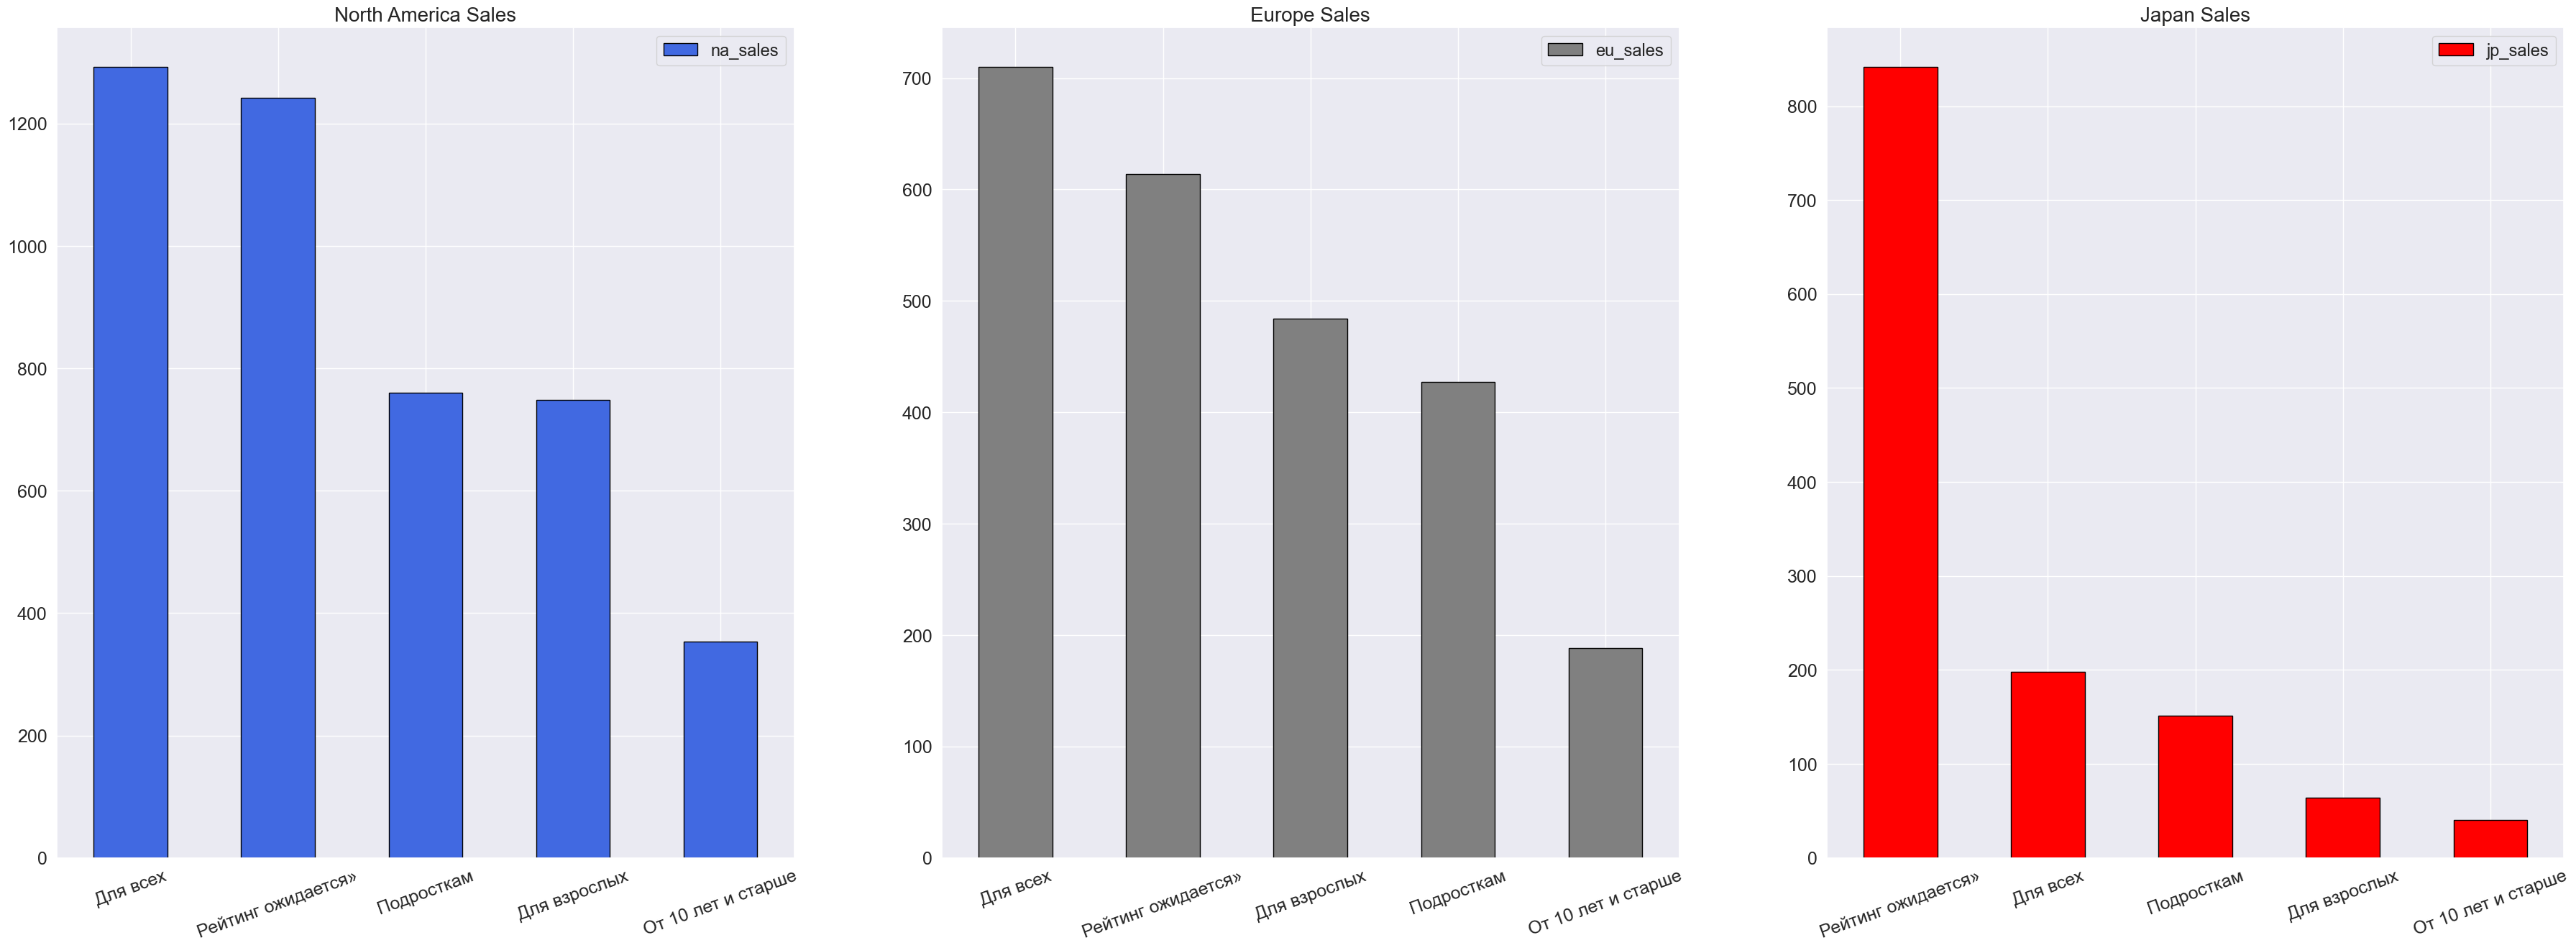

In [72]:
fig, axes = plt.subplots(1, 3, figsize=(45, 15))
top_in_regions_plot('ESRB_description', 'na_sales', 0)
top_in_regions_plot('ESRB_description', 'eu_sales', 1)
top_in_regions_plot('ESRB_description', 'jp_sales', 2)

В Северной Америке и в Европе картина похожа. Большая часть выручки получено с игр с рейтингом "Для всех", далее идет столбец - "Рейтинг ожидается, потом "Подросткам" и "Для взрослых". В европе все же у рейтинга "Для взрослых" чуть больше, значит там начинают играть не с самого раннего детства.

В Японии первое место такое же - "Рейтинг ожидается", а вот на втором - игры "Для всех" и "Подросткам". Стало быть в Японии играют с подросткового периода.

Анализируем платформы, всё, что не вошло в ТОП-5, объединяем в категорию "другие"

In [73]:
def platform_in_region(region):
    platform = actual_data_games_sales.groupby('platform')[region].sum().sort_values(ascending=False)
    platform.index = platform.index.where(platform.index.isin(platform.head().index), 'other')
    other = pd.Series([platform[platform.index=='other'].sum()], index=['other'])
    platform = platform[platform.index!='other']
    platform=pd.concat([platform, other], axis=0)
    return platform


In [74]:
platform_na = platform_in_region('na_sales')
platform_eu = platform_in_region('eu_sales')
platform_jp = platform_in_region('jp_sales')


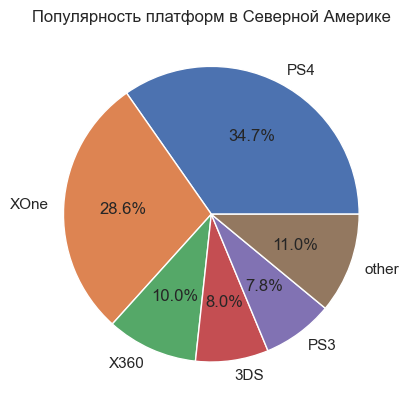

In [75]:
platform_na.plot(y='na_sales', x='platform', kind='pie',\
                   autopct='%1.1f%%', legend=False, title='Популярность платформ в Северной Америке')
plt.show()

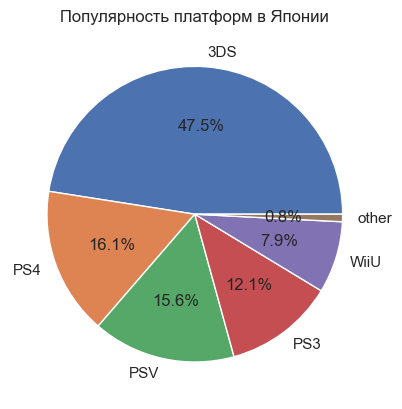

In [77]:
platform_jp.plot(y='jp_sales', x='platform', kind='pie',\
                   autopct='%1.1f%%', legend=False, title='Популярность платформ в Японии')
plt.show()

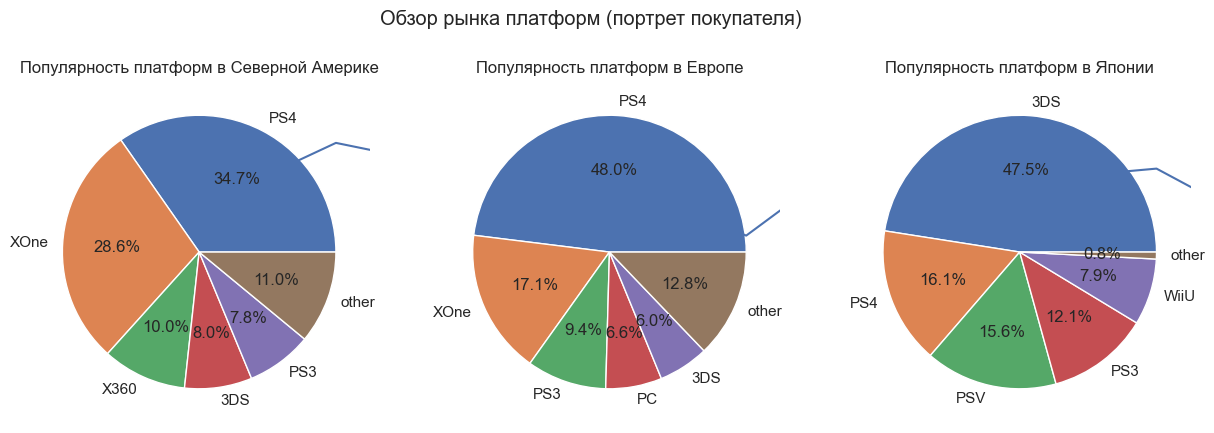

In [101]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
plt.suptitle('Обзор рынка платформ (портрет покупателя)')

# Первый подграфик для Северной Америки
axes[0].plot(np.random.random(10))
platform_na.plot(y='na_sales', x='platform', kind='pie',
                   autopct='%1.1f%%', legend=False, ax=axes[0])
axes[0].set_title('Популярность платформ в Северной Америке')

# Второй подграфик для Европы
axes[1].plot(np.random.random(10))
platform_eu.plot(y='eu_sales', x='platform', kind='pie',
                   autopct='%1.1f%%', legend=False, ax=axes[1])
axes[1].set_title('Популярность платформ в Европе')

# Третий подграфик для Японии
axes[2].plot(np.random.random(10))
platform_jp.plot(y='jp_sales', x='platform', kind='pie',
                   autopct='%1.1f%%', legend=False, ax=axes[2])
axes[2].set_title('Популярность платформ в Японии')

plt.show()


В данном анализе очевидно, что в актуальном периоде в Северной Америке борьба за первенство ведется между консолью Microsoft и Sony, однако Sony(PS4) впереди всего на несколько процентов. 
В Европе самый больший процент набрали PS4 и PS3. Что касается Японии, то там лидирует Нинтэндо, оно и понятно, ведь это их игровая система. Наверняка экономическая политика страны настроена продвигать собственный продукт на внутреннем рынке в большей степени.


<a id='step5'></a> ***Шаг 5. Проверим гипотезы***  

+ Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;  
+ Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные. 
+ Задайте самостоятельно пороговое значение alpha.  
+ Поясните:  
+ Как вы сформулировали нулевую и альтернативную гипотезы;  
+ Какой критерий применили для проверки гипотез и почему. 

"Средние пользовательские рейтинги платформ Xbox One и PC одинаковые".  

Для проверки данной гипотезы, необходимо воспользоваться методом проверки гипотезы о равенстве средних двух генеральных совокупностей.  

Сформулируем гипотезы:  
Нулевая гипотеза H₀: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;  
Альтернативная гипотеза H₁: Средние пользовательские рейтинги платформ Xbox One и PC различаются.

Чтобы проверить гипотезу о равенстве среднего двух генеральных совокупностей по взятым из них выборкам, воспользуюсь методом: scipy.stats.ttest_ind().


In [102]:
# Создаем series для платформы "XOne" со всеми оценками пользователей
data_xone = data.query('platform =="XOne" and user_score>=0 and year_of_release >= 2013')['user_score']
# Создаем series для платформы "PC" со всеми оценками пользователей
data_pc = data.query('platform =="PC" and user_score>=0 and year_of_release >= 2013')['user_score']

# Делаем выборку из 150 оценок пользователей для проверки гипотезы
data_pc = data_pc[0:150].tolist()

alpha = .05 # критический уровень статистической значимости
            # если p-value окажется больше него - отвергнем гипотезу
# Проверка нулевой гипотезы
results = st.ttest_ind(data_xone, data_pc)
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.1319064629834089
Не получилось отвергнуть нулевую гипотезу


Проверив нулевую гипотезу о равенстве средних двух генеральных совокупностей, нулевую гипотезу мы не отвергаем, это значит, что средние пользовательские рейтинги платформ Xbox One и PC не различаются.
_______________________

In [103]:
# Приведены два датасета: сумма покупок, совершённых за месяц посетителями ...

sample_1 = [3071, 3636, 3454, 3151, 2185, 3259, 1727, 2263, 2015,
2582, 4815, 633, 3186, 887, 2028, 3589, 2564, 1422, 1785,
3180, 1770, 2716, 2546, 1848, 4644, 3134, 475, 2686,
1838, 3352]
sample_2 = [1211, 1228, 2157, 3699, 600, 1898, 1688, 1420, 5048, 3007,
509, 3777, 5583, 3949, 121, 1674, 4300, 1338, 3066,
3562, 1010, 2311, 462, 863, 2021, 528, 1849, 255,
1740, 2596]
alpha = .05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу
results = st.ttest_ind(
sample_1,
sample_2)
print('p-значение:', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:

    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.1912450522572209
Не получилось отвергнуть нулевую гипотезу


In [104]:
# check
data_xone

165      7.9
179      5.4
242      6.4
270      6.2
373      4.1
        ... 
16544    6.8
16597    6.0
16630    8.2
16643    6.6
16660    6.7
Name: user_score, Length: 182, dtype: float64

"Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные".  

Для проверки данной гипотезы, необходимо воспользоваться методом проверки гипотезы о равенстве средних двух генеральных совокупностей.  

Сформулируем гипотезы:  
Нулевая гипотеза H₀: Средние пользовательские рейтинги жанра Action равны средним пользовательским рейтингам жанра Sports;  
Альтернативная гипотеза H₁: Средние пользовательские рейтинги жанра Action не равны средним пользовательским рейтингам жанра Sports.

Чтобы проверить гипотезу о равенстве среднего двух генеральных совокупностей по взятым из них выборкам, воспользуюсь методом: scipy.stats.ttest_ind().

In [105]:
# Создаю series для жанра "Action" со всеми оценками пользователей
data_action =data.query('genre =="Action" and user_score>=0 and year_of_release >= 2013')['user_score']
# Создаю series для жанра "Sports" со всеми оценками пользователей
data_sports = data.query('genre =="Sports" and user_score>=0 and year_of_release >= 2013')['user_score']

# Делаю выборку из 150 оценок пользователей для проверки гипотезы
data_action = data_action[0:150].tolist()
data_sports = data_sports[0:150].tolist()

alpha = .05 # критический уровень статистической значимости
            # если p-value окажется больше него - отвергнем гипотезу
# Проверка нулевой гипотезы
results = st.ttest_ind(data_action, data_sports)
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 1.5126918931234821e-19
Отвергаем нулевую гипотезу


Проверив нулевую гипотезу о равенстве средних двух генеральных совокупностей получилось отвергнуть нулевую гипотезу, это значит, что средние пользовательские рейтинги жанра Action не равны средним пользовательским рейтингам жанра Sports.
___________

Мы дошли до того, чтобы обсудить, как я сформулировала нулевую и альтернативную гипотезы; какой критерий применила для проверки гипотез и почему.

Я начала проверку гипотез начинается с формулировки нулевой гипотезы и альтернативной гипотезы.
После того как я сформулировала нулевую и альтернативную гипотезу, то начала на основе данных делать выбор: отвергнуть нулевую гипотезу в пользу альтернативной или нет.
Для этого нужно понять, насколько вероятно получить наблюдаемое на выборке значение среднее при условии, что нулевая гипотеза верна. Если вероятность большая — отвергать нулевую гипотезу навряд ли стоит.

Я сравнила средние двух генеральных совокупностей между собой.
Мне нужно было ответить на вопрос, какое из средних значений двух генеральных совокупностей больше. Одна из них содержит всего несколько тысяч записей, и ваш компьютер может рассчитать её среднее за разумное время, а другая гораздо больше, и о ней придётся судить по случайно взятой выборке...  

Однако в Python есть специальный метод для проверки гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам: scipy.stats.ttest_ind (array1, array2, equal_var).
У метода несколько параметров:  
+ array1, array2 — массивы, содержащие выборки;
+ equal_var (от англ. equal variance — «равная дисперсия») — необязательный параметр, задающий, считать ли равными дисперсии выборок. Передаётся как equal_var = True или equal_var = False (True — считать, False — не считать).  

Если параметр equal_var не указывать, то по умолчанию он примет значение True. Вопрос о том, в каком случае следует оставлять его таким, а в каком устанавливать как False, требует некоторого погружения в правила применимости t-теста.  

На практике гипотезы проверяются с помощью расчёта p-value — вероятности при верной нулевой гипотезе получить наблюдаемое значение или более удалённое от того, которое предположили в нулевой гипотезе. 
Уровень статистической значимости выбирается перед проведением статистического теста, а p-value — вероятность, которая вычисляется для конкретного эксперимента, то есть для уже взятой выборки.
Если p-value меньше выбранного уровня статистической значимости, то нулевая гипотеза отвергается в пользу альтернативной, — такой результат ещё называется значимым. А если больше, то не отвергается.
Чем меньше p-value, тем меньше оказалась вероятность хвостов, «отрубленных» наблюдаемым значением. Или хвоста, если альтернативная гипотеза односторонняя. И наоборот.  

Рассмотрим три аспекта, которые я проверила, чтобы понять, применять ли мне t-тест:
Выборочные средние должны быть нормально распределены. А если выборка всего одна, то её среднее должно иметь нормальное распределение для разных выборок этого размера из определённой генеральной совокупности. 
Часто это условие путают с необходимостью нормального распределения самих генеральных совокупностей. Для корректного использования t-теста это необязательно.  

В итоге, пришла к выводу, что у нас достаточно большие и равные по размеру выборки и нет оснований думать, что дисперсии генеральных совокупностей разные, я просто сравнила средние t-тестом, не указывая параметр equal_var: пусть он примет значение True. Но, если по какой-то причине выборки у меня были бы разного размера или появились сомнения, что дисперсии у совокупностей одинаковые, то я указала бы этот параметр как False, и тест посчитал бы дисперсии выборок по отдельности.




<a id='step6'></a> ***Шаг 6. Общий вывод***

В данном проекте мной был проведён исследовательский анализ данных о продажах игр, оценках пользователей и экспертов, а так же анализ игровых жанров и платформ.   
Так же были составлены портреты пользователей для таких регионов как NA, EU, JP. В ходе анализа было выявлено сколько игр выпускалось в разные годы, так же были изучены продажи для каждой платформы и определены платформы лидирующие по продажам. Было изучено влияние отзывов пользователей и критиков на продажи внутри платформы, проведено сравнение зависимости продаж игр на всех платформах. Также был выполнен анализ игровых жанров и прибыльности каждого жанра. Основываясь на полученных результатах исследования были проверены следующие гипотезы:   

Средние пользовательские рейтинги платформ Xbox One и PC одинаковые - гипотеза не отвергнута.  
Средние пользовательские рейтинги жанров Action и Sports разные - гипотеза не отвергнута.  

Было выявлено, что:  
По проведенному анализу: самое сильное влияние на итоговую выручку оказывают, в большинстве случаев, оценки критиков. Оценки пользователей такого "влияния" на выручку не имеют. 

В целом про положение дел в игровой индустрии: рынок "немобильных" игр постепенно погибает. Все в погоне за графикой, новыми технологями, в связи с этим средний бюджет на разработку одной игры за последние годы заметно вырос.   
В итоге, гиганты игровой индустрии гонятся за технологиями, а более мелкие компании, не имеющие таких бюджетов, вынуждены отступать, т.к. единственный их козырь - способность создать атмосферную игру, что не в приоритете у пользователя.
Это привело к тому, что рынок уже который год падает. 

Проанализировав пользовательские портреры в регионах NA, EU, JP можно выделить следующие сходства:

Во всех регионах наиболее популярным игровым жанром является Action.  
Во всех регионах игры с рейтингом ESRB равным M занимают наибольшую долю рынка.  
Во всех регионах игры с рейтингом ESRB равным E10+ и T занимают наименьшную долю рынка.  
Во всех регионах платформа PS4 является очень популярной.  

И о сходствах EU и NA пользователях:  
В Северной Америке популярны приставки Xone и PS4. Отстает x360. 
В Европе плюс-минус одинаково популярны PS4 и PS3. За ними X360, Wii и PS.  
В Японии безусловный лидер - 3DS. За ними американские PS3.

Наибольшую долю занимают игры жанра Action (экшен), далее идут Sport и Shooter.  

Популярные жанры Северной Америки и Европы похожи. И там, и там живут любители экшна, спортивных игр и шутеров. В Северной Америке больше играют в платформеры, в Европе же чаще выбирают гонки. Менее популярным жанром является Misc.  

О регионе JP:  
В Японии приоритеты в выборе жанров разительно отличаютя - на первом месте ролевые игры, причем с довольно большим отрывом от   остальных жанров. Далее экшны и спортивные игры. Платформеры и Misc, как и в Северной Америке - менее популярны.  

В ходе анализа удалось выяснить, что:  

Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
Средние пользовательские рейтинги жанра Action не равны средним пользовательским рейтингам жанра Sports.

Что касается планов на будущее, то могу предложить свои идеи. Возможно они покажутся фантаскикой, однако фантастикой когда-то казался тепловой двигатель внешнего сгорания, преобразующий энергию водяного пара в механическую работу возвратно-поступательного движения поршня, а теперь это вполне реальный опыт для человечества.  

Итак:   

4 тенденции, на которые имеет смысл обратить в будущем игр:  
1.  Графика, которая имеет способность сливаться с реальностью
2.  Машинное обучение: искусственный интеллект, способный к обучению
3.  Потоковое вещание игр, когда игры транслируются на весь мир
4.  Культура конвергенции, метавселенная. 
 